# Task 3 - Ensemble Learning

In [75]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from time                    import time
from sklearn.metrics         import accuracy_score, mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing   import LabelBinarizer as LB, StandardScaler, normalize
from sklearn.impute          import SimpleImputer

## Task 3.1 - Pre-Requisite

### Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier as DTC

### Logistic Regressor

In [33]:
class MultiLogRegressor():
    def __init__(self, epochs=1000, lr=0.01, progress=True):
        self.weights         = None
        self.biases          = None
        self.epochs          = epochs
        self.lr              = lr
        self.one_hot_encoder = None
        self.classes_        = None
        self.progress        = progress

    def __fit_one_hot(self, y):
        self.one_hot_encoder = LB()
        y_one_hot       = self.one_hot_encoder.fit_transform(y)
        self.classes_   = self.one_hot_encoder.classes_

        return y_one_hot
    
    def __get_one_hot(self, y):
        return self.one_hot_encoder.transform(y)

    def __softmax(self, X):
        y_pred       = X @ self.weights + self.biases
        y_pred_trunc = y_pred - np.max(y_pred, axis=1)[:, None]         # Subtracting by the max value of the column to prevent blowing up of exponentials

        return np.exp(y_pred_trunc) / np.sum(np.exp(y_pred_trunc), axis=1)[:, None]

    def __cross_entropy_loss(self, X, y_one_hot=None):
        return np.sum(-y_one_hot * np.log(self.__softmax(X), where=self.__softmax(X) > 1e-8)) / y_one_hot.shape[0]
    
    def __gradient_descent(self, X, y, y_one_hot):
        for i in range(self.epochs):
            y_pred_probs = self.__softmax(X)
            
            dw = (X.T @ (y_pred_probs - y_one_hot)) / X.shape[0]        # Partial derivative of {x_i * w_c + b_c} wrt w_c gives x_i^T, hence the transpose
            db = np.sum(y_pred_probs - y_one_hot, axis=0) / X.shape[0]
            
            self.weights -= self.lr * dw
            self.biases  -= self.lr * db

            loss     = self.__cross_entropy_loss(X, y_one_hot)
            accuracy = accuracy_score(y, self.predict(X))
            
            if self.progress is True and (i + 1) % 1000 == 0:
                print(f"Epoch {i + 1} ----- Loss: {loss} --- Accuracy: {accuracy}")
            
    def fit(self, X, y):
        y_one_hot    = self.__fit_one_hot(y)
        
        self.weights = np.zeros((X.shape[1], y_one_hot.shape[1]))
        self.biases  = np.zeros((1, y_one_hot.shape[1]))

        final_loss = self.__gradient_descent(X, y, y_one_hot)

        return final_loss
    
    def predict(self, X, y=None):
        scores = self.__softmax(X)

        class_indices = np.argmax(scores, axis=1)
        
        if y is None:
            return self.classes_[class_indices]
        
        else:
            y_one_hot = self.__get_one_hot(y)
            return self.classes_[class_indices], self.__cross_entropy_loss(X, y_one_hot)

    def predict_proba(self, X):
        return self.__softmax(X)

### MLP Classifier

In [34]:
class MLPClassifier():
    def __init__(self, lr=0.001, epochs=1000, activation='sigmoid', optimiser='Mini_Batch', num_batches=10, num_layers=2, num_neurons=np.array([15, 12]), progress=True):
        self.lr              = lr
        self.epochs          = epochs
        self.activation      = activation
        self.optimiser       = optimiser
        self.num_batches     = num_batches
        self.num_layers      = num_layers
        self.num_neurons     = num_neurons
        self.weights         = []
        self.biases          = []
        self.inner_outputs   = []
        self.one_hot_encoder = None
        self.classes_        = None
        self.progress        = progress

    def __fit_one_hot(self, y):
        self.one_hot_encoder = LB()
        y_one_hot     = self.one_hot_encoder.fit_transform(y)
        self.classes_ = self.one_hot_encoder.classes_

        return y_one_hot

    def __init_weights_biases(self, num_features, num_classes, rand=True):
        if rand is True:
            self.weights.append(np.random.randn(num_features, self.num_neurons[0]))
            self.biases.append( np.random.randn(1, self.num_neurons[0]))

            for i in range(self.num_layers - 1):
                self.weights.append(np.random.randn(self.num_neurons[i], self.num_neurons[i + 1]))
                self.biases.append( np.random.randn(1, self.num_neurons[i + 1]))

            self.weights.append(np.random.randn(self.num_neurons[-1], num_classes))
            self.biases.append( np.random.randn(1, num_classes))            

        else:
            self.weights.append(np.zeros((num_features, self.num_neurons[0])))
            self.biases.append( np.zeros((1, self.num_neurons[0])))

            for i in range(self.num_layers - 1):
                self.weights.append(np.zeros((self.num_neurons[i], self.num_neurons[i + 1])))
                self.biases.append( np.zeros((1, self.num_neurons[i + 1])))

            self.weights.append(np.zeros((self.num_neurons[-1], num_classes)))
            self.biases.append( np.zeros((1, num_classes)))

    def __init_inner_outputs(self, num_samples, num_classes):
        for i in range(self.num_layers):
            self.inner_outputs.append(np.zeros((num_samples, self.num_neurons[i])))
        self.inner_outputs.append(np.zeros((num_samples, num_classes)))

    # Activation functions
    def __sigmoid(self, X):
        X_trunc = X - np.max(X, axis=1)[:, None]
        return np.exp(X_trunc) / np.sum(np.exp(X_trunc), axis=1)[:, None]
    
    def __tanh(self, X):
        return np.tanh(X)
    
    def __relu(self, X):
        return (np.maximum(0, X) % 1e9) + 1e-8

    def __activation(self, X, activation_type=None):
        activation_type = activation_type or self.activation

        if activation_type == 'sigmoid':
            return self.__sigmoid(X)
        elif activation_type == 'tanh':
            return self.__tanh(X)
        elif activation_type == 'relu':
            return self.__relu(X)
    
    # Derivatives of activation functions to be used in backpropagation
    def __sigmoid_derivative(self, X):
        return X * (1 - X)
    
    def __tanh_derivative(self, X):
        return 1 - np.square(X)
    
    def __relu_derivative(self, X):
        return np.where(X > 0, 1, 0)

    def __activation_derivative(self, X, activation_type=None):
        activation_type = activation_type or self.activation
        
        if activation_type == 'sigmoid':
            return self.__sigmoid_derivative(X)
        elif activation_type == 'tanh':
            return self.__tanh_derivative(X)
        elif activation_type == 'relu':
            return self.__relu_derivative(X)
        
    def __softmax(self, X):
        X_trunc = X - np.max(X, axis=1)[:, None]
        return np.exp(X_trunc) / np.sum(np.exp(X_trunc), axis=1)[:, None]

    def __forward_prop(self, X):
        self.inner_outputs[0] = self.__activation(X @ self.weights[0] + self.biases[0])

        for i in range(1, self.num_layers + 1):
            activation_type = 'relu' if i == self.num_layers else self.activation
            self.inner_outputs[i] = self.__activation(self.inner_outputs[i - 1] @ self.weights[i] + self.biases[i], activation_type=activation_type)

        self.inner_outputs[-1] = self.__softmax(self.inner_outputs[-1])

    def __SGD(self, X, y_one_hot):
        for j in range(X.shape[0]):
            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                if i == self.num_layers:
                    dA = (self.__activation_derivative(self.inner_outputs[i][j], activation_type) * (self.inner_outputs[i][j] - y_one_hot[j]))[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = X[j][:, None] @ dA
                    dB = dA

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __batch_descent(self, X, y_one_hot):
        for i in range(self.num_layers, -1, -1):
            activation_type = 'relu' if i == self.num_layers else self.activation

            if i == self.num_layers:
                dA = (self.__activation_derivative(self.inner_outputs[i], activation_type) * (self.inner_outputs[i] - y_one_hot))
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            elif i == 0:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = X.T @ dA
                dB = np.sum(dA, axis=0)

            else:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            self.weights[i] -= self.lr * dW
            self.biases[i]  -= self.lr * dB

    def __mini_batch_descent(self, X, y_one_hot):
        for batch_num in range(self.num_batches):
            X_batch = X[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
            y_batch = y_one_hot[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                inner_output = self.inner_outputs[i][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

                if i == self.num_layers:
                    dA = (self.__activation_derivative(inner_output, activation_type) * (inner_output - y_batch))

                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)
                    dW = X_batch.T @ dA
                    dB = np.sum(dA, axis=0)

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)
                    
                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __back_prop(self, X, y_one_hot):
        if self.optimiser == 'SGD':
            self.__SGD(X, y_one_hot)
        elif self.optimiser == 'Batch':
            self.__batch_descent(X, y_one_hot)
        elif self.optimiser == 'Mini_Batch':
            self.__mini_batch_descent(X, y_one_hot)

    def __cross_entropy_loss(self, y_one_hot=None):
        return np.sum(-y_one_hot * np.log(self.inner_outputs[-1], where=self.inner_outputs[-1] > 1e-8)) / y_one_hot.shape[0]

    def fit(self, X, y):
        y_one_hot = self.__fit_one_hot(y)

        self.__init_weights_biases(X.shape[1], self.one_hot_encoder.classes_.shape[0])
        self.__init_inner_outputs( X.shape[1], self.one_hot_encoder.classes_.shape[0])

        for i in range(self.epochs):
            self.__forward_prop(X)
            self.__back_prop(X, y_one_hot)

            pred_labels, loss = self.predict(X, y)
            accuracy = accuracy_score(y, pred_labels)

            if self.progress is True and (i + 1) % 100 == 0:
                print(f"Epoch {i + 1} ----- Loss: {loss} ----- Accuracy: {accuracy}")

    def predict(self, X, y=None):
        self.__forward_prop(X)
        class_indices = np.argmax(self.inner_outputs[-1], axis=1)

        if y is None:
            return self.classes_[class_indices]

        else:
            y_one_hot = self.__fit_one_hot(y)
            return self.classes_[class_indices], self.__cross_entropy_loss(y_one_hot)
        
    def predict_proba(self, X):
        self.__forward_prop(X)
        return self.inner_outputs[-1]

## Task 3.2 - Bagging

In [35]:
wine_df = pd.read_csv("./Data/WineQT.csv")
wine_df = wine_df.drop(columns=["Id"])
display(wine_df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [36]:
np.random.seed(27)

wine_df_values = wine_df.to_numpy()
wine_df_X, wine_df_Y = wine_df_values[:, :-1], wine_df_values[:, -1]

wine_train_X, wine_val_test_X, wine_train_Y, wine_val_test_Y = train_test_split(wine_df_X, wine_df_Y, train_size=0.7, stratify=wine_df_Y)
wine_val_X, wine_test_X, wine_val_Y, wine_test_Y = train_test_split(wine_val_test_X, wine_val_test_Y, train_size=0.5, stratify=wine_val_test_Y)

In [37]:
# Replacing missing values with mean of the respective columns/features
wine_train_X = SimpleImputer().fit_transform(wine_train_X)
wine_val_X   = SimpleImputer().fit_transform(wine_val_X)
wine_test_X  = SimpleImputer().fit_transform(wine_test_X)

# Dataset normalization
wine_train_X = normalize(wine_train_X)
wine_val_X   = normalize(wine_val_X)
wine_test_X  = normalize(wine_test_X)

# Dataset standardization
wine_train_X = StandardScaler().fit_transform(wine_train_X)
wine_val_X   = StandardScaler().fit_transform(wine_val_X)
wine_test_X  = StandardScaler().fit_transform(wine_test_X)

### Decision Tree Classifier Tuning

In [38]:
# criteria   = ["gini", "entropy", "log_loss"]
# max_depths = [2, 3, 5, 10, None]
# max_leaves = [3, 6, 10, 16, None]

# DTC_params_df = pd.DataFrame(columns=["Criterion", "Max_Depth", "Max_Leaves", "Train_Accuracy", "Val_Accuracy", "Test_Accuracy"])

# for criterion in criteria:
#     for max_depth in max_depths:
#         for max_leaf in max_leaves:
#             DTC_model = DTC(criterion=criterion, max_depth=max_depth, max_leaf_nodes=max_leaf)
#             DTC_model.fit(wine_train_X, wine_train_Y)

#             model_params = {
#                 "Criterion"      : criterion,
#                 "Max_Depth"      : max_depth,
#                 "Max_Leaves"     : max_leaf,
#                 "Train_Accuracy" : accuracy_score(wine_train_Y, DTC_model.predict(wine_train_X)),
#                 "Val_Accuracy"   : accuracy_score(wine_val_Y, DTC_model.predict(wine_val_X)),
#                 "Test_Accuracy"  : accuracy_score(wine_test_Y, DTC_model.predict(wine_test_X))
#             }

#             DTC_params_df = pd.concat([DTC_params_df, pd.DataFrame([model_params])], ignore_index=True)

# DTC_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# display(DTC_params_df)

,Criterion,Max_Depth,Max_Leaves,Train_Accuracy,Val_Accuracy,Test_Accuracy
19,gini,10,None,0.86000,0.614035,0.494186
18,gini,10,16,0.60250,0.596491,0.459302
23,gini,None,16,0.60250,0.596491,0.459302
13,gini,5,16,0.59375,0.584795,0.441860
17,gini,10,10,0.57125,0.578947,0.470930
...,...,...,...,...,...,...
64,log_loss,5,None,0.61250,0.532164,0.500000
63,log_loss,5,16,0.57000,0.532164,0.482558
69,log_loss,10,None,0.86625,0.520468,0.465116
49,entropy,None,None,1.00000,0.514620,0.453488


### Logistic Regressor Tuning

In [39]:
# epochs_list    = [1000, 5000, 10000]
# learning_rates = [0.001, 0.01, 0.1]

# multi_log_reg_params_df = pd.DataFrame(columns=["Epochs", "Learning_Rate", "Train_Accuracy", "Val_Accuracy", "Test_Accuracy"])

# for epochs in epochs_list:
#     for lr in learning_rates:
#         multi_log_reg_model = MultiLogRegressor(epochs=epochs, lr=lr, progress=False)
#         multi_log_reg_model.fit(wine_train_X, wine_train_Y)

#         model_params = {
#             "Epochs"         : epochs,
#             "Learning_Rate"  : lr,
#             "Train_Accuracy" : accuracy_score(wine_train_Y, multi_log_reg_model.predict(wine_train_X)),
#             "Val_Accuracy"   : accuracy_score(wine_val_Y, multi_log_reg_model.predict(wine_val_X)),
#             "Test_Accuracy"  : accuracy_score(wine_test_Y, multi_log_reg_model.predict(wine_test_X))
#         }

#         multi_log_reg_params_df = pd.concat([multi_log_reg_params_df, pd.DataFrame([model_params])], ignore_index=True)

# multi_log_reg_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# display(multi_log_reg_params_df)

,Epochs,Learning_Rate,Train_Accuracy,Val_Accuracy,Test_Accuracy
5,5000,0.100,0.61000,0.631579,0.610465
2,1000,0.100,0.58375,0.619883,0.633721
7,10000,0.010,0.58250,0.619883,0.633721
8,10000,0.100,0.63625,0.619883,0.604651
4,5000,0.010,0.56500,0.584795,0.627907
1,1000,0.010,0.51750,0.555556,0.552326
6,10000,0.001,0.51750,0.555556,0.552326
3,5000,0.001,0.50250,0.549708,0.540698
0,1000,0.001,0.47625,0.520468,0.459302


### MLP Classifier Tuning

In [40]:
# epochs_list    = [1000, 5000, 10000]
# learning_rates = [0.001, 0.01, 0.1]
# num_layers     = [1, 2, 3]
# num_neurons    = [np.array([15]), np.array([15, 12]), np.array([15, 12, 10])]

# MLP_params_df = pd.DataFrame(columns=["Epochs", "Learning_Rate", "Num_Layers", "Num_Neurons", "Train_Accuracy", "Val_Accuracy", "Test_Accuracy"])

# for epochs in epochs_list:
#     for lr in learning_rates:
#         for i, num_layer in enumerate(num_layers):
#             MLP_model = MLPClassifier(lr=lr, epochs=epochs, num_layers=num_layer, num_neurons=num_neurons[i], activation='sigmoid', optimiser='Mini_Batch', num_batches=10, progress=False)
#             MLP_model.fit(wine_train_X, wine_train_Y)

#             model_params = {
#                 "Epochs"         : epochs,
#                 "Learning_Rate"  : lr,
#                 "Num_Layers"     : num_layer,
#                 "Num_Neurons"    : num_neurons[i],
#                 "Train_Accuracy" : accuracy_score(wine_train_Y, MLP_model.predict(wine_train_X)),
#                 "Val_Accuracy"   : accuracy_score(wine_val_Y, MLP_model.predict(wine_val_X)),
#                 "Test_Accuracy"  : accuracy_score(wine_test_Y, MLP_model.predict(wine_test_X))
#             }

#             MLP_params_df = pd.concat([MLP_params_df, pd.DataFrame([model_params])], ignore_index=True)

# MLP_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# display(MLP_params_df)

,Epochs,Learning_Rate,Num_Layers,Num_Neurons,Train_Accuracy,Val_Accuracy,Test_Accuracy
11,5000,0.001,3,"[15, 12, 10]",0.64375,0.660819,0.598837
9,5000,0.001,1,[15],0.62375,0.625731,0.593023
1,1000,0.001,2,"[15, 12]",0.54875,0.625731,0.581395
18,10000,0.001,1,[15],0.62125,0.614035,0.598837
10,5000,0.001,2,"[15, 12]",0.57625,0.590643,0.581395
22,10000,0.010,2,"[15, 12]",0.57000,0.584795,0.569767
19,10000,0.001,2,"[15, 12]",0.62375,0.584795,0.587209
0,1000,0.001,1,[15],0.56125,0.578947,0.552326
2,1000,0.001,3,"[15, 12, 10]",0.51000,0.567251,0.511628
20,10000,0.001,3,"[15, 12, 10]",0.54250,0.561404,0.569767


## Task 3.2.1 - Bagging Classifier Class

In [47]:
class EnsembleClassifier():
    def __init__(self, base_model_type='DT', num_estimators=10, fraction=0.5, bootstrap=True, voting='soft', progress=True):
        self.base_model_type = base_model_type
        self.num_estimators  = num_estimators
        self.fraction        = fraction
        self.bootstrap       = bootstrap
        self.voting          = voting
        self.progress        = progress
        self.classes_        = None

        self.models          = []

    def __init_model(self):
        if self.base_model_type == 'DT':
            return DTC(criterion="gini", max_depth=10, max_leaf_nodes=None)
        elif self.base_model_type == 'Logistic':
            return MultiLogRegressor(epochs=5000, lr=0.1, progress=False)
        elif self.base_model_type == 'MLP':
            return MLPClassifier(lr=0.001, epochs=5000, num_layers=1, num_neurons=[18], activation='sigmoid', optimiser='Mini_Batch', num_batches=10, progress=False)

    def __data_sampler(self, X, y):
        indices = np.random.choice(X.shape[0], int(X.shape[0] * self.fraction), replace=self.bootstrap)
        X_sampled, y_sampled = X[indices], y[indices]

        if len(np.unique(y_sampled)) != len(np.unique(y)):
            for i in np.unique(y):
                if i not in y_sampled:
                    index = np.random.choice(np.where(y == i)[0], replace=self.bootstrap)
                    X_sampled = np.vstack((X_sampled, np.reshape(X[index], (1, -1))))
                    y_sampled = np.concatenate((y_sampled, np.reshape(y[index], -1)))

        return X_sampled, y_sampled

    def fit(self, X, y):
        self.models = []

        for i in range(self.num_estimators):
            model = self.__init_model()

            X_sample, y_sample = self.__data_sampler(X, y)

            if self.progress is True:
                print(f"Fitting model {i + 1}/{self.num_estimators}...")

            model.fit(X_sample, y_sample)
            self.models.append(model)

        self.classes_ = self.models[0].classes_

    def predict(self, X):
        if self.voting == 'soft':
            predictions = []

            for model in self.models:
                predictions.append(model.predict_proba(X))

            predictions   = np.mean(predictions, axis=0)
            class_indices = np.argmax(predictions, axis=1)

            return self.classes_[class_indices]

        elif self.voting == 'hard':
            predictions = []

            for model in self.models:
                predictions.append(model.predict(X))

            predictions = np.array(predictions)

            return np.array([max(np.unique(predictions), key = lambda x: np.sum(predictions[:, col] == x)) for col in range(predictions.shape[1])])

I have used ChatGPT to generate the code for the predictions for hard voting. I wrote the return statement of the `elif self.voting == 'hard` block using ChatGPT. The conversation can be found [here](https://chat.openai.com/share/712efe15-3c27-4f90-9b9a-9d07d9bce0fd)

In [48]:
ensem_model = EnsembleClassifier()
ensem_model.fit(wine_train_X, wine_train_Y)

Fitting model 1/10...
Fitting model 2/10...
Fitting model 3/10...
Fitting model 4/10...
Fitting model 5/10...
Fitting model 6/10...
Fitting model 7/10...
Fitting model 8/10...
Fitting model 9/10...
Fitting model 10/10...


In [49]:
preds = ensem_model.predict(wine_val_X)
score = accuracy_score(wine_val_Y, preds)
print(f"Validation Accuracy: {score}")

Validation Accuracy: 0.6432748538011696


## Task 3.2.2 - Hyperparameter tuning for Ensemble Classifier

In [52]:
# base_estimator_types  = ['DT', 'Logistic', 'MLP']
# num_estimators_values = [3, 5]
# fraction_values       = [0.15, 0.25, 0.5, 0.75, 1]
# bootstrap_values      = [True, False]
# voting_values         = ['soft', 'hard']

# ensem_classifier_params_df = pd.DataFrame(columns=["Base_Estimator_Type", "Num_Estimators", "Fraction", "Bootstrap", "Voting", "Train_Accuracy", "Val_Accuracy", "Test_Accuracy"])
# num_fitted = 0

# for base_estimator_type in base_estimator_types:
#     for num_estimators in num_estimators_values:
#         for fraction in fraction_values:
#             for bootstrap in bootstrap_values:
#                 for voting in voting_values:
#                     ensem_model = EnsembleClassifier(base_model_type=base_estimator_type, num_estimators=num_estimators, fraction=fraction, bootstrap=bootstrap, voting=voting, progress=False)
#                     ensem_model.fit(wine_train_X, wine_train_Y)

#                     num_fitted += 1
#                     print(f"Model {base_estimator_type} - {num_estimators} - {fraction} - {bootstrap} - {voting} fitted...{num_fitted}/120")

#                     model_params = {
#                         "Base_Estimator_Type" : base_estimator_type,
#                         "Num_Estimators"      : num_estimators,
#                         "Fraction"            : fraction,
#                         "Bootstrap"           : bootstrap,
#                         "Voting"              : voting,
#                         "Train_Accuracy"      : accuracy_score(wine_train_Y, ensem_model.predict(wine_train_X)),
#                         "Val_Accuracy"        : accuracy_score(wine_val_Y,   ensem_model.predict(wine_val_X)),
#                         "Test_Accuracy"       : accuracy_score(wine_test_Y,  ensem_model.predict(wine_test_X))
#                     }

#                     ensem_classifier_params_df = pd.concat([ensem_classifier_params_df, pd.DataFrame([model_params])], ignore_index=True)

# dt_ensem_classifier_params_df  = ensem_classifier_params_df[ensem_classifier_params_df["Base_Estimator_Type"] == 'DT']
# dt_ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("DT Ensemble Classifier Parameters")
# display(dt_ensem_classifier_params_df)
# print("=================================\n")

# log_ensem_classifier_params_df = ensem_classifier_params_df[ensem_classifier_params_df["Base_Estimator_Type"] == 'Logistic']
# log_ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)

# print("Logistic Ensemble Classifier Parameters")
# display(log_ensem_classifier_params_df)
# print("=================================\n")

# mlp_ensem_classifier_params_df = ensem_classifier_params_df[ensem_classifier_params_df["Base_Estimator_Type"] == 'MLP']
# mlp_ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("MLP Ensemble Classifier Parameters")
# display(mlp_ensem_classifier_params_df)
# print("=================================\n")

# ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("Ensemble Classifier Parameters")
# display(ensem_classifier_params_df)
# print("=================================\n")

Model DT - 3 - 0.15 - True - soft fitted...1/120
Model DT - 3 - 0.15 - True - hard fitted...2/120
Model DT - 3 - 0.15 - False - soft fitted...3/120
Model DT - 3 - 0.15 - False - hard fitted...4/120
Model DT - 3 - 0.25 - True - soft fitted...5/120
Model DT - 3 - 0.25 - True - hard fitted...6/120
Model DT - 3 - 0.25 - False - soft fitted...7/120
Model DT - 3 - 0.25 - False - hard fitted...8/120
Model DT - 3 - 0.5 - True - soft fitted...9/120
Model DT - 3 - 0.5 - True - hard fitted...10/120
Model DT - 3 - 0.5 - False - soft fitted...11/120
Model DT - 3 - 0.5 - False - hard fitted...12/120
Model DT - 3 - 0.75 - True - soft fitted...13/120
Model DT - 3 - 0.75 - True - hard fitted...14/120
Model DT - 3 - 0.75 - False - soft fitted...15/120
Model DT - 3 - 0.75 - False - hard fitted...16/120
Model DT - 3 - 1 - True - soft fitted...17/120
Model DT - 3 - 1 - True - hard fitted...18/120
Model DT - 3 - 1 - False - soft fitted...19/120
Model DT - 3 - 1 - False - hard fitted...20/120
Model DT - 5 - 

/tmp/ipykernel_18167/3947999030.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Accuracy,Val_Accuracy,Test_Accuracy
38,DT,5,1.00,False,soft,0.86375,0.625731,0.465116
18,DT,3,1.00,False,soft,0.86250,0.619883,0.511628
33,DT,5,0.75,True,hard,0.86500,0.608187,0.523256
39,DT,5,1.00,False,hard,0.86125,0.602339,0.511628
28,DT,5,0.50,True,soft,0.80375,0.602339,0.488372
19,DT,3,1.00,False,hard,0.86250,0.596491,0.511628
34,DT,5,0.75,False,soft,0.94125,0.590643,0.523256
25,DT,5,0.25,True,hard,0.68750,0.590643,0.459302
15,DT,3,0.75,False,hard,0.86250,0.584795,0.482558
36,DT,5,1.00,True,soft,0.90375,0.578947,0.470930



Logistic Ensemble Classifier Parameters


/tmp/ipykernel_18167/3947999030.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Accuracy,Val_Accuracy,Test_Accuracy
66,Logistic,5,0.25,False,soft,0.59875,0.654971,0.575581
74,Logistic,5,0.75,False,soft,0.61500,0.649123,0.622093
54,Logistic,3,0.75,False,soft,0.62250,0.649123,0.633721
50,Logistic,3,0.50,False,soft,0.61875,0.643275,0.604651
42,Logistic,3,0.15,False,soft,0.57125,0.637427,0.593023
70,Logistic,5,0.50,False,soft,0.61000,0.637427,0.622093
68,Logistic,5,0.50,True,soft,0.61125,0.637427,0.622093
75,Logistic,5,0.75,False,hard,0.61500,0.637427,0.616279
69,Logistic,5,0.50,True,hard,0.62375,0.631579,0.622093
67,Logistic,5,0.25,False,hard,0.61000,0.631579,0.604651



MLP Ensemble Classifier Parameters


/tmp/ipykernel_18167/3947999030.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlp_ensem_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Accuracy,Val_Accuracy,Test_Accuracy
115,MLP,5,0.75,False,hard,0.64000,0.678363,0.656977
93,MLP,3,0.75,True,hard,0.59125,0.666667,0.593023
118,MLP,5,1.00,False,soft,0.65250,0.660819,0.622093
94,MLP,3,0.75,False,soft,0.62500,0.649123,0.627907
109,MLP,5,0.50,True,hard,0.63500,0.649123,0.616279
110,MLP,5,0.50,False,soft,0.63500,0.649123,0.575581
112,MLP,5,0.75,True,soft,0.63250,0.649123,0.546512
99,MLP,3,1.00,False,hard,0.62250,0.649123,0.616279
98,MLP,3,1.00,False,soft,0.62250,0.643275,0.587209
97,MLP,3,1.00,True,hard,0.57750,0.643275,0.517442



Ensemble Classifier Parameters


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Accuracy,Val_Accuracy,Test_Accuracy
115,MLP,5,0.75,False,hard,0.64000,0.678363,0.656977
93,MLP,3,0.75,True,hard,0.59125,0.666667,0.593023
118,MLP,5,1.00,False,soft,0.65250,0.660819,0.622093
66,Logistic,5,0.25,False,soft,0.59875,0.654971,0.575581
74,Logistic,5,0.75,False,soft,0.61500,0.649123,0.622093
...,...,...,...,...,...,...,...,...
1,DT,3,0.15,True,hard,0.55625,0.479532,0.441860
20,DT,5,0.15,True,soft,0.60375,0.479532,0.459302
8,DT,3,0.50,True,soft,0.73375,0.479532,0.540698
9,DT,3,0.50,True,hard,0.72500,0.461988,0.488372


## Task 3.2.3 - Accuracy heatmap for each base model on num_estimators vs data_fraction

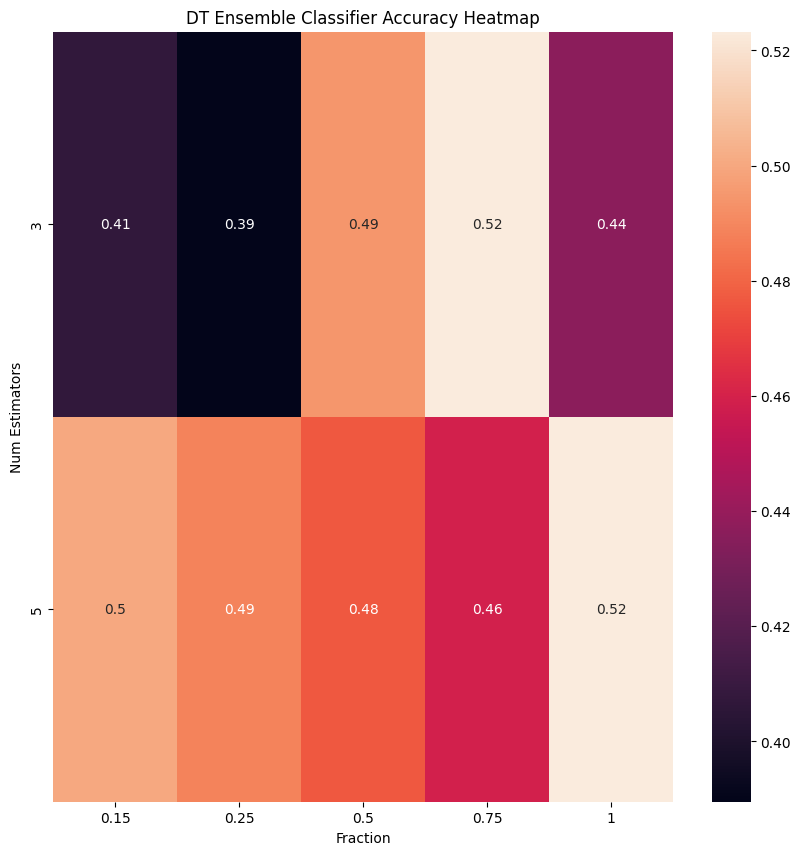

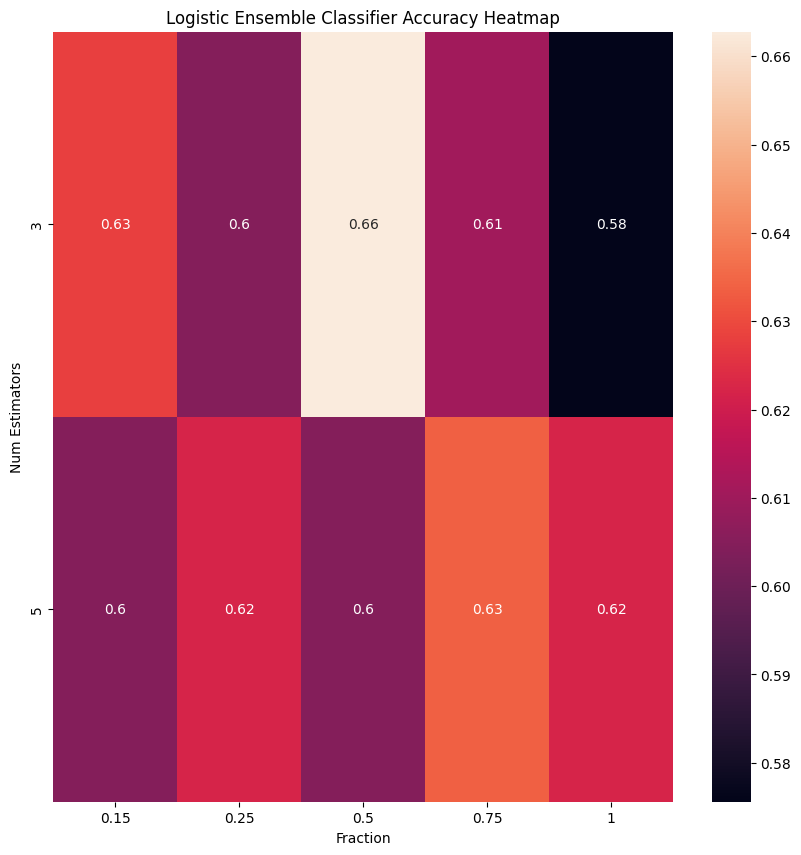

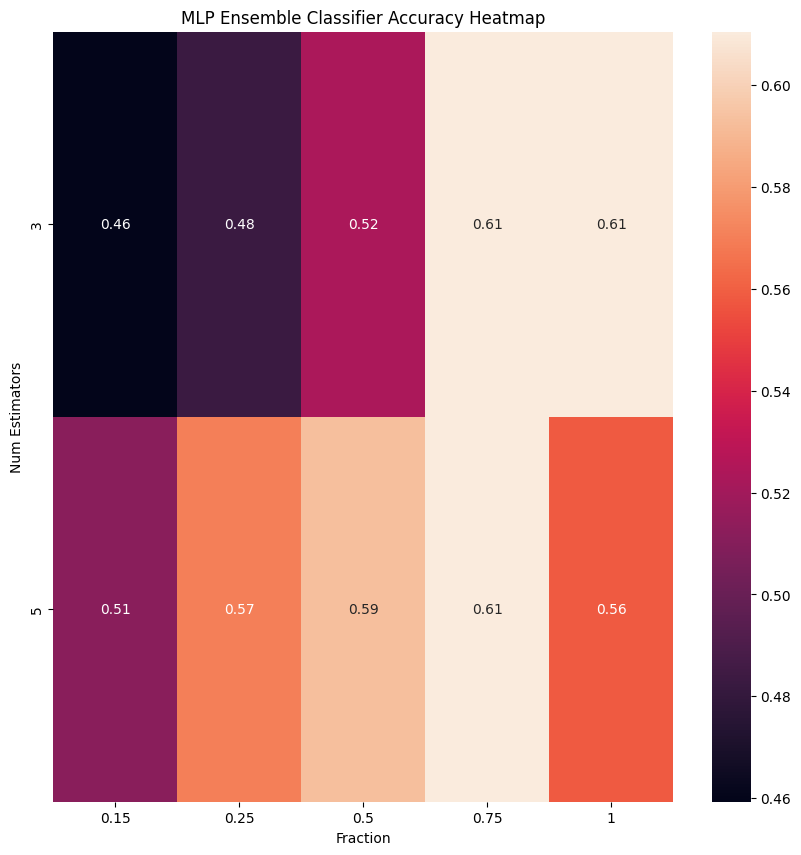

In [54]:
base_models    = ["DT", "Logistic", "MLP"]
num_estimators = [3, 5]
fractions      = [0.15, 0.25, 0.5, 0.75, 1]

for model_index, model_type in enumerate(base_models):
    plt.figure(figsize=(10, 10))

    heatmap_accs = np.zeros((len(num_estimators), len(fractions)))

    for i, num_estimator in enumerate(num_estimators):
        for j, fraction in enumerate(fractions):
            ensem_model = EnsembleClassifier(base_model_type=model_type, num_estimators=num_estimator, fraction=fraction, bootstrap=True, voting='soft', progress=False)
            ensem_model.fit(wine_train_X, wine_train_Y)

            heatmap_accs[i, j] = accuracy_score(wine_test_Y, ensem_model.predict(wine_test_X))

    sns.heatmap(heatmap_accs, annot=True, xticklabels=fractions, yticklabels=num_estimators)
    plt.xlabel("Fraction")
    plt.ylabel("Num Estimators")
    plt.title(f"{model_type} Ensemble Classifier Accuracy Heatmap")

    plt.show()

## Task 3.2.4 - Comparision of individual models vs ensemble model

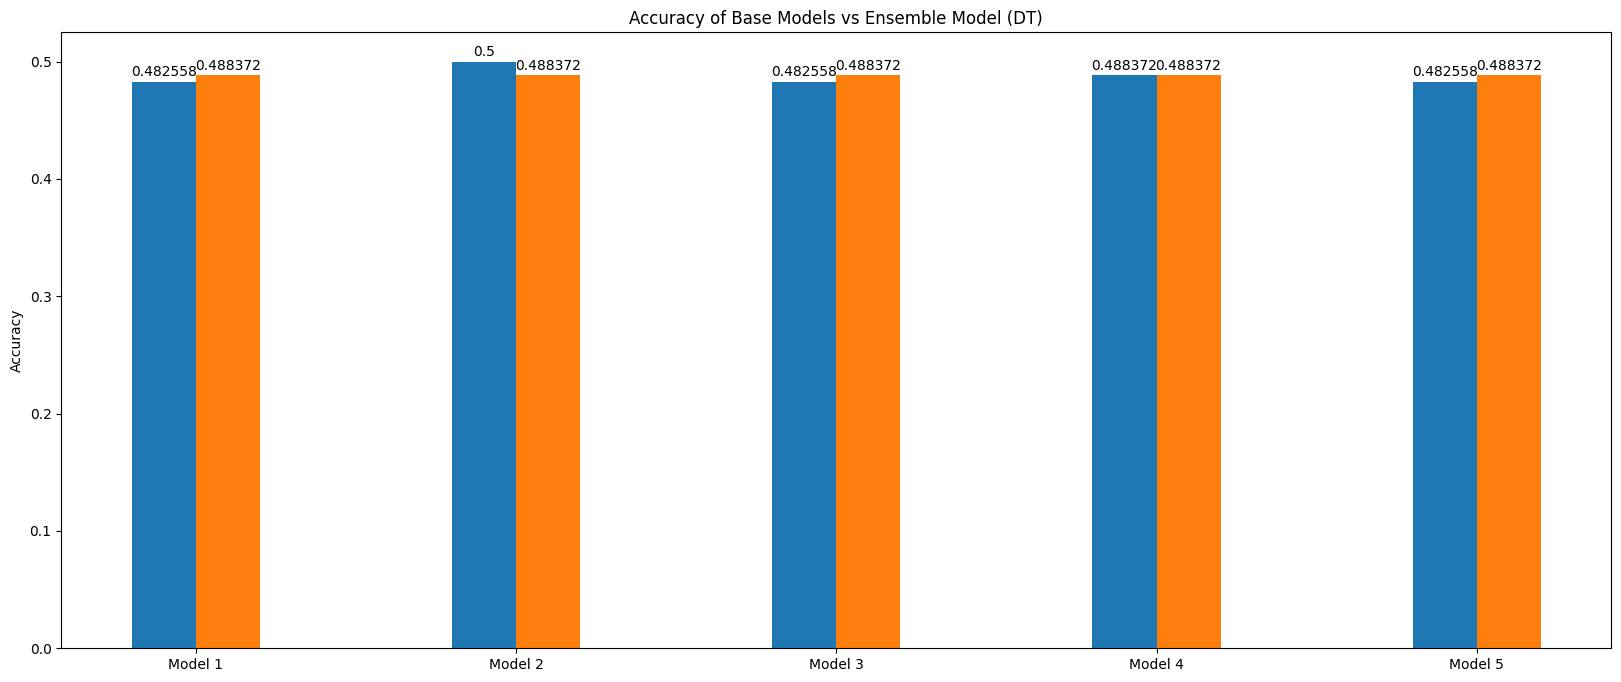

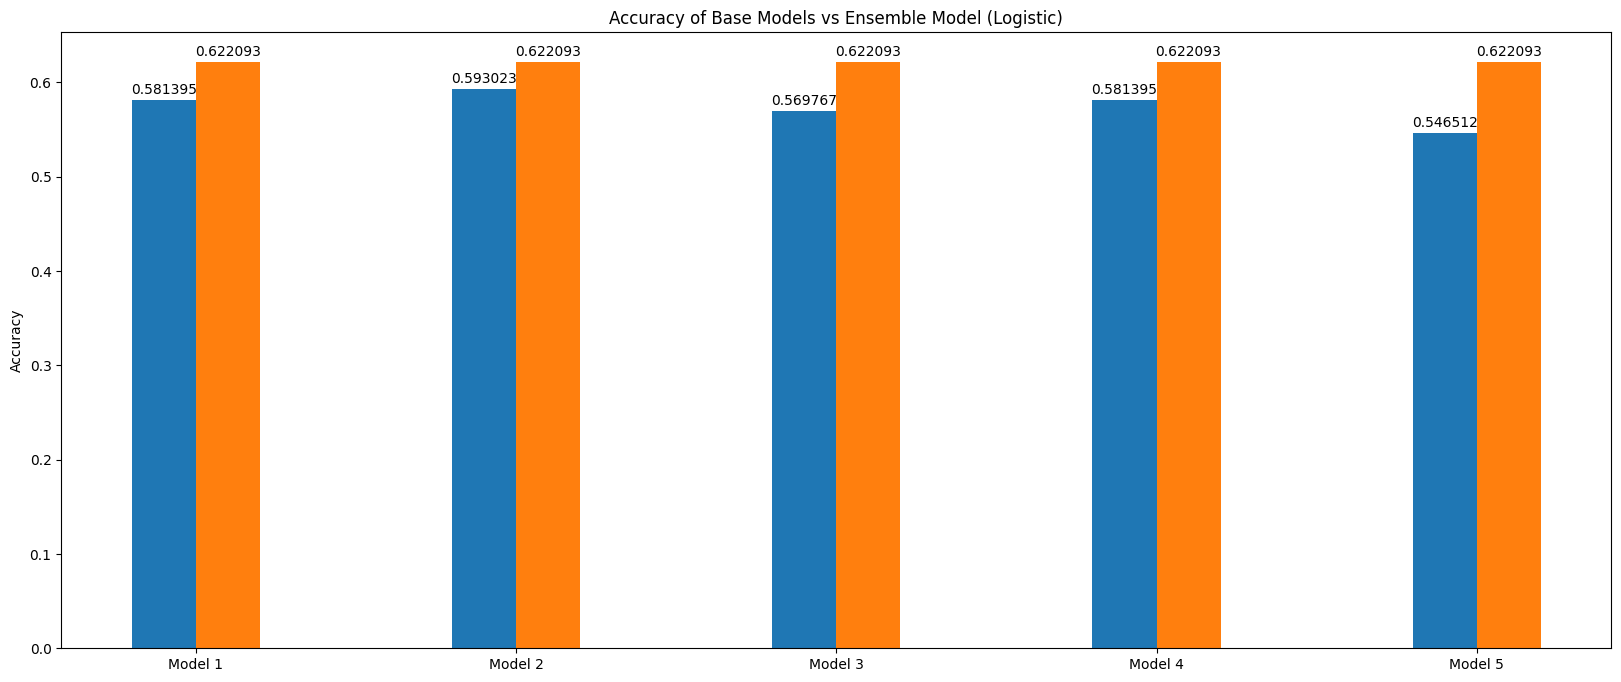

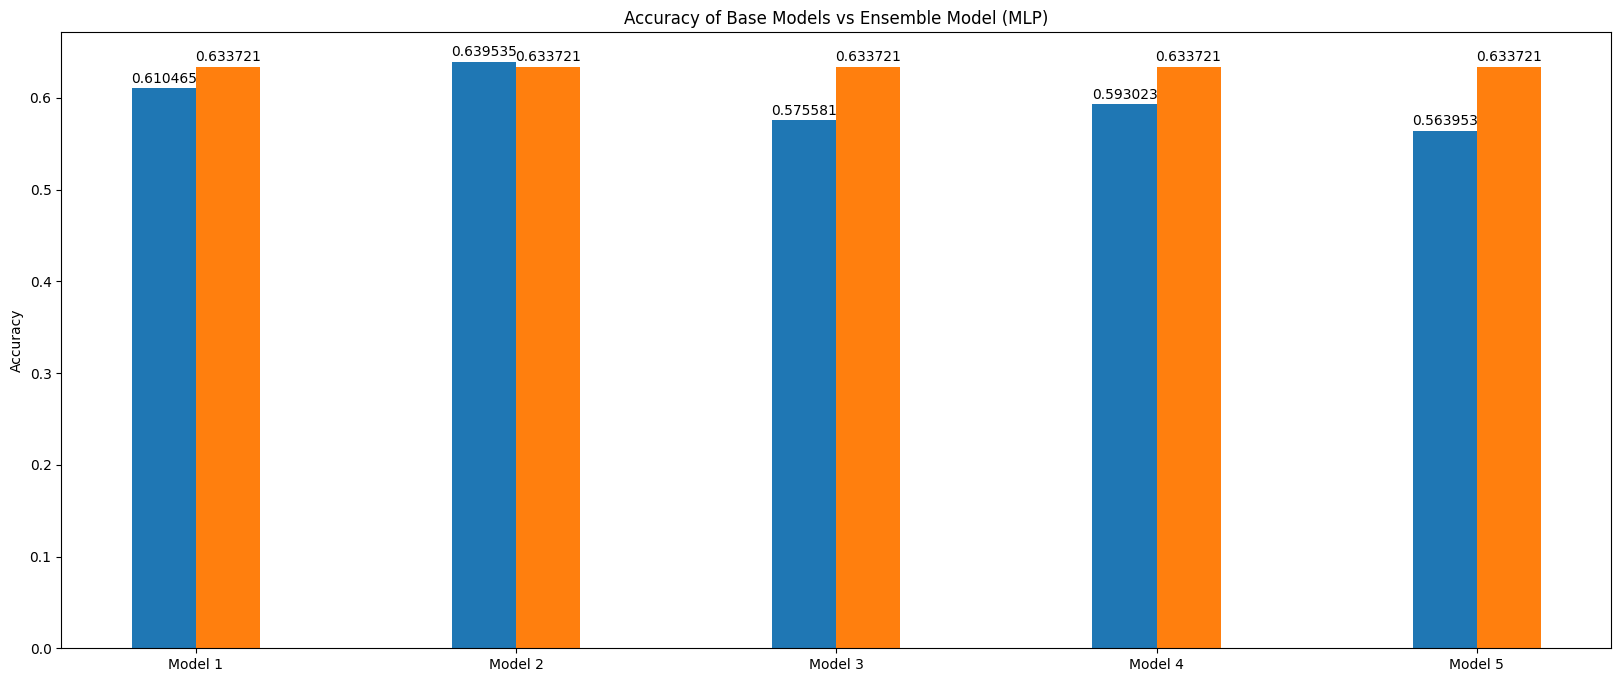

In [53]:
best_base_models = [
    EnsembleClassifier(base_model_type='DT',       num_estimators=5, fraction=1,    bootstrap=False, voting='soft', progress=False),
    EnsembleClassifier(base_model_type='Logistic', num_estimators=5, fraction=0.25, bootstrap=False, voting='soft', progress=False),
    EnsembleClassifier(base_model_type='MLP',      num_estimators=5, fraction=0.75, bootstrap=False, voting='hard', progress=False)
]

for model_index, best_model in enumerate(best_base_models):
    plt.figure(figsize=(20, 8))

    best_model.fit(wine_train_X, wine_train_Y)

    acc_scores = []

    for model in best_model.models:
        acc_scores.append(accuracy_score(wine_test_Y, model.predict(wine_test_X)))

    x = np.arange(len(best_model.models))
    width = 0.2
    multiplier = 0

    base_bar = plt.bar(x, acc_scores, width, label=acc_scores)
    plt.bar_label(base_bar, padding=2)

    acc_score = accuracy_score(wine_test_Y, best_model.predict(wine_test_X))
    model_bar = plt.bar(x + width, [acc_score] * len(best_model.models), width, label=acc_score)
    plt.bar_label(model_bar, padding=2)

    plt.ylabel('Accuracy')
    plt.xticks(x + width / 2, [f"Model {i + 1}" for i in range(len(best_model.models))])
    plt.title(f"Accuracy of Base Models vs Ensemble Model ({best_model.base_model_type})")

    plt.show()

### Decision Tree Regressor

In [18]:
from sklearn.tree import DecisionTreeRegressor  as DTR

### Linear Regressor

In [25]:
class LinearRegresor():
    def __init__(self, progress=True):
        self.weights  = None
        self.biases   = None
        self.progress = progress

    def __mean_squared_error(self, y, y_pred):
        return np.sum((y_pred - y) ** 2) / y.shape[0]

    def fit(self, X, y):
        y = np.reshape(y, (-1, 1))

        self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        self.biases  = np.mean(y - X @ self.weights)

        y_pred = X @ self.weights + self.biases
        final_loss = self.__mean_squared_error(y, y_pred)

        return final_loss

    def predict(self, X):
        return X @ self.weights + self.biases

### MLP Regressor

In [20]:
class MLPRegressor():
    def __init__(self, lr=0.001, epochs=1000, activation='sigmoid', optimiser='Mini_Batch', num_batches=10, num_layers=5, num_neurons=np.array([15, 18, 10, 8, 5]), loss_function='MSE', progress=True):
        self.lr              = lr
        self.epochs          = epochs
        self.activation      = activation
        self.optimiser       = optimiser
        self.num_batches     = num_batches
        self.num_layers      = num_layers
        self.num_neurons     = num_neurons
        self.weights         = []
        self.biases          = []
        self.inner_outputs   = []
        self.loss_function   = loss_function
        self.progress        = progress

    def __init_weights_biases(self, num_features, rand=True):
        if rand is True:
            self.weights.append(np.random.randn(num_features, self.num_neurons[0]))
            self.biases.append( np.random.randn(1, self.num_neurons[0]))

            for i in range(self.num_layers - 1):
                self.weights.append(np.random.randn(self.num_neurons[i], self.num_neurons[i + 1]))
                self.biases.append( np.random.randn(1, self.num_neurons[i + 1]))

            self.weights.append(np.random.randn(self.num_neurons[-1], 1))
            self.biases.append( np.random.randn(1, 1))

        else:
            self.weights.append(np.zeros((num_features, self.num_neurons[0])))
            self.biases.append( np.zeros((1, self.num_neurons[0])))

            for i in range(self.num_layers - 1):
                self.weights.append(np.zeros((self.num_neurons[i], self.num_neurons[i + 1])))
                self.biases.append( np.zeros((1, self.num_neurons[i + 1])))

            self.weights.append(np.zeros((self.num_neurons[-1], 1)))
            self.biases.append( np.zeros((1, 1)))

    def __init_inner_outputs(self, num_samples):
        for i in range(self.num_layers):
            self.inner_outputs.append(np.zeros((num_samples, self.num_neurons[i])))
        self.inner_outputs.append(np.zeros((num_samples, 1)))

    # Activation functions
    def __sigmoid(self, X):
        X_trunc = X - np.max(X, axis=1)[:, None]
        return np.exp(X_trunc) / np.sum(np.exp(X_trunc), axis=1)[:, None]
    
    def __tanh(self, X):
        return np.tanh(X)
    
    def __relu(self, X):
        return (np.maximum(0, X) % 1e9) + 1e-8

    def __activation(self, X, activation_type=None):
        activation_type = activation_type or self.activation

        if activation_type == 'sigmoid':
            return self.__sigmoid(X)
        elif activation_type == 'tanh':
            return self.__tanh(X)
        elif activation_type == 'relu':
            return self.__relu(X)
    
    # Derivatives of activation functions to be used in backpropagation
    def __sigmoid_derivative(self, X):
        return X * (1 - X)
    
    def __tanh_derivative(self, X):
        return 1 - np.square(X)
    
    def __relu_derivative(self, X):
        return np.where(X > 0, 1, 0)

    def __activation_derivative(self, X, activation_type=None):
        activation_type = activation_type or self.activation
        
        if activation_type == 'sigmoid':
            return self.__sigmoid_derivative(X)
        elif activation_type == 'tanh':
            return self.__tanh_derivative(X)
        elif activation_type == 'relu':
            return self.__relu_derivative(X)

    def __forward_prop(self, X):
        self.inner_outputs[0] = self.__activation(X @ self.weights[0] + self.biases[0])

        for i in range(1, self.num_layers + 1):
            activation_type = 'relu' if i == self.num_layers else self.activation
            self.inner_outputs[i] = self.__activation(self.inner_outputs[i - 1] @ self.weights[i] + self.biases[i], activation_type=activation_type)

    def __SGD(self, X, y):
        for j in range(X.shape[0]):
            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                if i == self.num_layers:
                    dA = (self.__activation_derivative(self.inner_outputs[i][j], activation_type) * (self.inner_outputs[i][j] - y[j]))[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = X[j][:, None] @ dA
                    dB = dA

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __batch_descent(self, X, y):
        for i in range(self.num_layers, -1, -1):
            activation_type = 'relu' if i == self.num_layers else self.activation

            if i == self.num_layers:
                dA = (self.__activation_derivative(self.inner_outputs[i], activation_type) * (self.inner_outputs[i] - y))
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            elif i == 0:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = X.T @ dA
                dB = np.sum(dA, axis=0)

            else:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            self.weights[i] -= self.lr * dW
            self.biases[i]  -= self.lr * dB

    def __mini_batch_descent(self, X, y):
        for batch_num in range(self.num_batches):
            X_batch = X[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
            y_batch = y[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                inner_output = self.inner_outputs[i][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

                if i == self.num_layers:
                    dA = (self.__activation_derivative(inner_output, activation_type) * (inner_output - y_batch))

                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)
                    dW = X_batch.T @ dA
                    dB = np.sum(dA, axis=0)

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)

                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __back_prop(self, X, y):
        if self.optimiser == 'SGD':
            self.__SGD(X, y)
        elif self.optimiser == 'Batch':
            self.__batch_descent(X, y)
        elif self.optimiser == 'Mini_Batch':
            self.__mini_batch_descent(X, y)

    def __mse(self, y):
        return np.mean(np.square(y - self.inner_outputs[-1]))

    def __rmse(self, y):
        return np.sqrt(self.__mse(y))

    def __r_squared(self, y):
        return 1 - (self.__mse(y) / np.var(y))

    def __loss_function(self, y, metric=None):
        metric = self.loss_function if metric is None else metric
        if metric == 'MSE':
            return self.__mse(y)
        elif metric == 'RMSE':
            return self.__rmse(y)
        elif metric == 'R_Squared':
            return self.__r_squared(y)

    def fit(self, X, y):
        y = np.reshape(y, (-1, 1))

        self.__init_weights_biases(X.shape[1])
        self.__init_inner_outputs( X.shape[1])

        for i in range(self.epochs):
            self.__forward_prop(X)
            self.__back_prop(X, y)

            _, loss = self.predict(X, y)

            if self.progress is True and (i + 1) % 100 == 0:
                print(f"Epoch {i + 1} ----- Loss: {loss}")

    def predict(self, X, y=None, metric=None):
        self.__forward_prop(X)

        if y is None:
            return self.inner_outputs[-1]
        else:
            return self.inner_outputs[-1], self.__loss_function(y, metric=metric)

In [21]:
housing_df = pd.read_csv("./Data/HousingData.csv")
housing_df_values = housing_df.to_numpy()
display(housing_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [22]:
np.random.seed(364)

housing_df_X, housing_df_Y = housing_df_values[:, :-1], housing_df_values[:, -1]

housing_train_X, housing_val_test_X, housing_train_Y, housing_val_test_Y = train_test_split(housing_df_X,       housing_df_Y,       train_size=0.7)
housing_val_X,   housing_test_X,     housing_val_Y,   housing_test_Y     = train_test_split(housing_val_test_X, housing_val_test_Y, train_size=0.5)

In [23]:
# Replacing missing values with mean of the respective columns/features
housing_train_X = SimpleImputer().fit_transform(housing_train_X)
housing_val_X   = SimpleImputer().fit_transform(housing_val_X)
housing_test_X  = SimpleImputer().fit_transform(housing_test_X)

# Dataset normalization
housing_train_X = normalize(housing_train_X)
housing_val_X   = normalize(housing_val_X)
housing_test_X  = normalize(housing_test_X)

# Dataset standardization
housing_train_X = StandardScaler().fit_transform(housing_train_X)
housing_val_X   = StandardScaler().fit_transform(housing_val_X)
housing_test_X  = StandardScaler().fit_transform(housing_test_X)

### Decision Tree Regressor Tuning

In [26]:
# criteria = ["squared_error", "friedman_mse", "absolute_error", "poisson"]
# max_depths = [2, 3, 5, 10, None]
# max_leaves = [3, 6, 10, 16, None]

# DTR_params_df = pd.DataFrame(columns=["Criterion", "Max_Depth", "Max_Leaves", "Train_Loss", "Val_Loss", "Test_Loss"])

# for criterion in criteria:
#     for max_depth in max_depths:
#         for max_leaf in max_leaves:
#             DTR_model = DTR(criterion=criterion, max_depth=max_depth, max_leaf_nodes=max_leaf)
#             DTR_model.fit(housing_train_X, housing_train_Y)

#             model_params = {
#                 "Criterion"  : criterion,
#                 "Max_Depth"  : max_depth,
#                 "Max_Leaves" : max_leaf,
#                 "Train_Loss" : mse(housing_train_Y, DTR_model.predict(housing_train_X)),
#                 "Val_Loss"   : mse(housing_val_Y, DTR_model.predict(housing_val_X)),
#                 "Test_Loss"  : mse(housing_test_Y, DTR_model.predict(housing_test_X))
#             }

#             DTR_params_df = pd.concat([DTR_params_df, pd.DataFrame([model_params])], ignore_index=True)

# DTR_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
# display(DTR_params_df)

,Criterion,Max_Depth,Max_Leaves,Train_Loss,Val_Loss,Test_Loss
64,absolute_error,5,None,8.406525,14.748388,38.742007
18,squared_error,10,16,10.000610,15.540839,19.481969
43,friedman_mse,10,16,10.000610,15.540839,19.481969
48,friedman_mse,None,16,10.000610,15.540839,19.481969
23,squared_error,None,16,10.000610,15.540839,19.481969
...,...,...,...,...,...,...
50,absolute_error,2,3,46.003503,49.416053,60.546316
55,absolute_error,3,3,46.003503,49.416053,60.546316
60,absolute_error,5,3,46.003503,49.416053,60.546316
70,absolute_error,None,3,46.003503,49.416053,60.546316


### MLP Regressor Tuning

In [27]:
# epochs_list    = [1000, 5000, 10000]
# learning_rates = [0.001, 0.01, 0.1]
# num_layers     = [1, 3, 6]
# num_neurons    = [np.array([15]), np.array([15, 12, 10]), np.array([15, 12, 10, 8, 6, 4])]

# MLP_params_df = pd.DataFrame(columns=["Epochs", "Learning_Rate", "Num_Layers", "Num_Neurons", "Train_Loss", "Val_Loss", "Test_Loss"])

# for epochs in epochs_list:
#     for lr in learning_rates:
#         for i, num_layer in enumerate(num_layers):
#             MLP_model = MLPRegressor(lr=lr, epochs=epochs, num_layers=num_layer, num_neurons=num_neurons[i], activation='sigmoid', optimiser='Mini_Batch', num_batches=10, progress=False)
#             MLP_model.fit(housing_train_X, housing_train_Y)

#             model_params = {
#                 "Epochs"       : epochs,
#                 "Learning_Rate": lr,
#                 "Num_Layers"   : num_layer,
#                 "Num_Neurons"  : num_neurons[i],
#                 "Train_Loss"   : mse(housing_train_Y, MLP_model.predict(housing_train_X)),
#                 "Val_Loss"     : mse(housing_val_Y, MLP_model.predict(housing_val_X)),
#                 "Test_Loss"    : mse(housing_test_Y, MLP_model.predict(housing_test_X))
#             }

#             MLP_params_df = pd.concat([MLP_params_df, pd.DataFrame([model_params])], ignore_index=True)

# MLP_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
# display(MLP_params_df)

,Epochs,Learning_Rate,Num_Layers,Num_Neurons,Train_Loss,Val_Loss,Test_Loss
18,10000,0.001,1,[15],8.601544,16.230863,25.565131
1,1000,0.001,3,"[15, 12, 10]",23.174555,25.129994,38.456871
9,5000,0.001,1,[15],13.491612,26.337188,30.904115
10,5000,0.001,3,"[15, 12, 10]",13.960855,27.255267,25.578373
0,1000,0.001,1,[15],16.862793,33.860565,31.156456
19,10000,0.001,3,"[15, 12, 10]",30.848328,38.085076,33.412663
2,1000,0.001,6,"[15, 12, 10, 8, 6, 4]",80.983253,81.715833,103.167667
20,10000,0.001,6,"[15, 12, 10, 8, 6, 4]",80.983312,81.715903,103.167698
11,5000,0.001,6,"[15, 12, 10, 8, 6, 4]",80.983378,81.715949,103.167775
12,5000,0.010,1,[15],103.549819,134.808069,112.211976


## Task 3.2.1 - Bagging Regressor Class

In [81]:
class EnsembleRegressor():
    def __init__(self, base_model_type='DT', num_estimators=10, fraction=0.5, bootstrap=True, voting='soft', progress=True):
        self.base_model_type = base_model_type
        self.num_estimators  = num_estimators
        self.fraction        = fraction
        self.bootstrap       = bootstrap
        self.voting          = voting
        self.progress        = progress

        self.models          = []

    def __init_model(self):
        if self.base_model_type == 'DT':
            return DTR(criterion="absolute_error", max_depth=10, max_leaf_nodes=None)
        elif self.base_model_type == 'Linear':
            return LinearRegresor(progress=False)
        elif self.base_model_type == 'MLP':
            return MLPRegressor(lr=0.001, epochs=10000, num_layers=1, num_neurons=[15], activation='sigmoid', optimiser='Mini_Batch', num_batches=10, progress=False)

    def __data_sampler(self, X, y):
        indices = np.random.choice(X.shape[0], int(X.shape[0] * self.fraction), replace=self.bootstrap)
        X_sampled, y_sampled = X[indices], y[indices]

        return X_sampled, y_sampled

    def fit(self, X, y):
        for i in range(self.num_estimators):
            model = self.__init_model()

            X_sample, y_sample = self.__data_sampler(X, y)

            if self.progress is True:
                print(f"Fitting model {i + 1}/{self.num_estimators}...")

            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X, y_true):
        if self.voting == 'soft':
            predictions = []
            confidences = []

            for model in self.models:
                prediction = model.predict(X)
                predictions.append(prediction)
                confidences.append(1 / mse(y_true, prediction))

            predictions   = np.reshape(predictions, (len(self.models), -1))
            confidences   = np.reshape(confidences, (-1, 1))

            weighted_predictions = np.sum(predictions * confidences, axis=0) / np.sum(confidences)

            return weighted_predictions

        elif self.voting == 'hard':
            predictions = []

            for model in self.models:
                predictions.append(model.predict(X))

            return np.mean(predictions, axis=0)

In [82]:
ensem_model = EnsembleRegressor()
ensem_model.fit(housing_train_X, housing_train_Y)

Fitting model 1/10...
Fitting model 2/10...
Fitting model 3/10...
Fitting model 4/10...
Fitting model 5/10...
Fitting model 6/10...
Fitting model 7/10...
Fitting model 8/10...
Fitting model 9/10...
Fitting model 10/10...


In [83]:
preds = ensem_model.predict(housing_val_X, housing_val_Y)
score = mse(housing_val_Y, preds)
print(f"Validation MSE: {score}")

Validation MSE: 17.196935952822287


## Task 3.2.2 - Hyperparameter tuning for Ensemble Regressor

In [113]:
base_estimator_types  = ['DT', 'Linear', 'MLP']
num_estimators_values = [3, 5]
fraction_values       = [0.15, 0.25, 0.5, 0.75, 1]
bootstrap_values      = [True, False]
voting_values         = ['soft', 'hard']

ensem_regressor_params_df = pd.DataFrame(columns=["Base_Estimator_Type", "Num_Estimators", "Fraction", "Bootstrap", "Voting", "Train_Loss", "Val_Loss", "Test_Loss"])
num_fitted = 0

for base_estimator_type in base_estimator_types:
    for num_estimators in num_estimators_values:
        for fraction in fraction_values:
            for bootstrap in bootstrap_values:
                for voting in voting_values:
                    ensem_model = EnsembleRegressor(base_model_type=base_estimator_type, num_estimators=num_estimators, fraction=fraction, bootstrap=bootstrap, voting=voting, progress=False)
                    ensem_model.fit(housing_train_X, housing_train_Y)

                    num_fitted += 1
                    print(f"Model {base_estimator_type} - {num_estimators} - {fraction} - {bootstrap} - {voting} fitted...{num_fitted}/120")

                    model_params = {
                        "Base_Estimator_Type" : base_estimator_type,
                        "Num_Estimators"      : num_estimators,
                        "Fraction"            : fraction,
                        "Bootstrap"           : bootstrap,
                        "Voting"              : voting,
                        "Train_Loss"          : mse(housing_train_Y, ensem_model.predict(housing_train_X, housing_train_Y)),
                        "Val_Loss"            : mse(housing_val_Y,   ensem_model.predict(housing_val_X,   housing_val_Y)),
                        "Test_Loss"           : mse(housing_test_Y,  ensem_model.predict(housing_test_X,  housing_test_Y))
                    }

                    ensem_regressor_params_df = pd.concat([ensem_regressor_params_df, pd.DataFrame([model_params])], ignore_index=True)

dt_ensem_regressor_params_df  = ensem_regressor_params_df[ensem_regressor_params_df["Base_Estimator_Type"] == 'DT']
dt_ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
print("DT Ensemble Regressor Parameters")
display(dt_ensem_regressor_params_df)
print("=================================\n")

lin_ensem_regressor_params_df = ensem_regressor_params_df[ensem_regressor_params_df["Base_Estimator_Type"] == 'Linear']
lin_ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)

print("Linear Ensemble Regressor Parameters")
display(lin_ensem_regressor_params_df)
print("=================================\n")

mlp_ensem_regressor_params_df = ensem_regressor_params_df[ensem_regressor_params_df["Base_Estimator_Type"] == 'MLP']
mlp_ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
print("MLP Ensemble Regressor Parameters")
display(mlp_ensem_regressor_params_df)
print("=================================\n")

ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
print("Ensemble Regressor Parameters")
display(ensem_regressor_params_df)
print("=================================\n")

Model DT - 3 - 0.15 - True - soft fitted...1/120
Model DT - 3 - 0.15 - True - hard fitted...2/120
Model DT - 3 - 0.15 - False - soft fitted...3/120
Model DT - 3 - 0.15 - False - hard fitted...4/120
Model DT - 3 - 0.25 - True - soft fitted...5/120
Model DT - 3 - 0.25 - True - hard fitted...6/120
Model DT - 3 - 0.25 - False - soft fitted...7/120
Model DT - 3 - 0.25 - False - hard fitted...8/120
Model DT - 3 - 0.5 - True - soft fitted...9/120
Model DT - 3 - 0.5 - True - hard fitted...10/120
Model DT - 3 - 0.5 - False - soft fitted...11/120
Model DT - 3 - 0.5 - False - hard fitted...12/120
Model DT - 3 - 0.75 - True - soft fitted...13/120
Model DT - 3 - 0.75 - True - hard fitted...14/120
Model DT - 3 - 0.75 - False - soft fitted...15/120
Model DT - 3 - 0.75 - False - hard fitted...16/120
Model DT - 3 - 1 - True - soft fitted...17/120
Model DT - 3 - 1 - True - hard fitted...18/120
Model DT - 3 - 1 - False - soft fitted...19/120
Model DT - 3 - 1 - False - hard fitted...20/120
Model DT - 5 - 

/tmp/ipykernel_18167/1764874865.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Loss,Val_Loss,Test_Loss
34,DT,5,0.75,False,soft,3.739968,8.187060,16.384208
36,DT,5,1.00,True,soft,5.038054,8.941474,17.763571
16,DT,3,1.00,True,soft,6.469782,9.094525,12.114169
30,DT,5,0.50,False,soft,5.880675,10.198809,16.188184
32,DT,5,0.75,True,soft,6.231996,10.819813,17.142847
10,DT,3,0.50,False,soft,9.255364,10.901623,23.207543
35,DT,5,0.75,False,hard,2.817000,11.020846,15.204712
17,DT,3,1.00,True,hard,7.844788,12.120523,26.061758
14,DT,3,0.75,False,soft,3.363604,12.208471,14.140079
33,DT,5,0.75,True,hard,7.428241,12.264745,21.012275



Linear Ensemble Regressor Parameters


/tmp/ipykernel_18167/1764874865.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Loss,Val_Loss,Test_Loss
74,Linear,5,0.75,False,soft,22.522913,16.189433,30.684859
59,Linear,3,1.00,False,hard,21.299952,18.480010,31.508200
58,Linear,3,1.00,False,soft,21.299952,18.480010,31.508200
79,Linear,5,1.00,False,hard,21.299952,18.480010,31.508200
78,Linear,5,1.00,False,soft,21.299952,18.480010,31.508200
54,Linear,3,0.75,False,soft,23.443919,19.818510,34.312098
55,Linear,3,0.75,False,hard,23.337884,20.270395,35.821090
75,Linear,5,0.75,False,hard,22.689861,21.199015,36.226533
70,Linear,5,0.50,False,soft,25.904468,22.278317,33.876516
57,Linear,3,1.00,True,hard,25.232663,23.396524,39.256778



MLP Ensemble Regressor Parameters


/tmp/ipykernel_18167/1764874865.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlp_ensem_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Loss,Val_Loss,Test_Loss
96,MLP,3,1.00,True,soft,13.094490,12.046815,19.506050
118,MLP,5,1.00,False,soft,7.379124,12.503393,19.186375
117,MLP,5,1.00,True,hard,8.710136,12.969306,21.373406
108,MLP,5,0.50,True,soft,13.355433,13.153564,17.965413
112,MLP,5,0.75,True,soft,13.219870,13.304352,18.186024
113,MLP,5,0.75,True,hard,14.256125,14.667557,21.560655
114,MLP,5,0.75,False,soft,9.744026,15.047629,21.290676
93,MLP,3,0.75,True,hard,16.671506,15.636501,24.621286
116,MLP,5,1.00,True,soft,11.332182,15.882961,16.890570
110,MLP,5,0.50,False,soft,13.974316,15.909817,24.932774



Ensemble Regressor Parameters


,Base_Estimator_Type,Num_Estimators,Fraction,Bootstrap,Voting,Train_Loss,Val_Loss,Test_Loss
34,DT,5,0.75,False,soft,3.739968,8.187060,16.384208
36,DT,5,1.00,True,soft,5.038054,8.941474,17.763571
16,DT,3,1.00,True,soft,6.469782,9.094525,12.114169
30,DT,5,0.50,False,soft,5.880675,10.198809,16.188184
32,DT,5,0.75,True,soft,6.231996,10.819813,17.142847
...,...,...,...,...,...,...,...,...
67,Linear,5,0.25,False,hard,192.600835,163.257492,173.774228
43,Linear,3,0.15,False,hard,194.742926,207.320654,169.702447
61,Linear,5,0.15,True,hard,261.238697,239.005547,200.582103
63,Linear,5,0.15,False,hard,251.233782,252.063147,217.878951


## Task 3.2.3 - Loss heatmap for each base model on num_estimators vs data_fraction

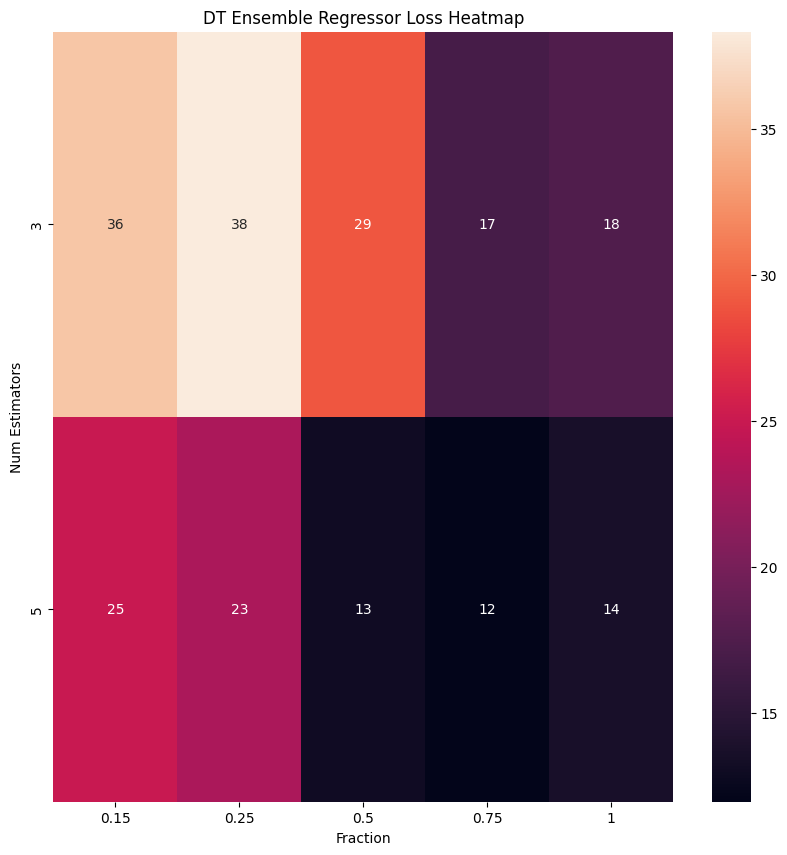

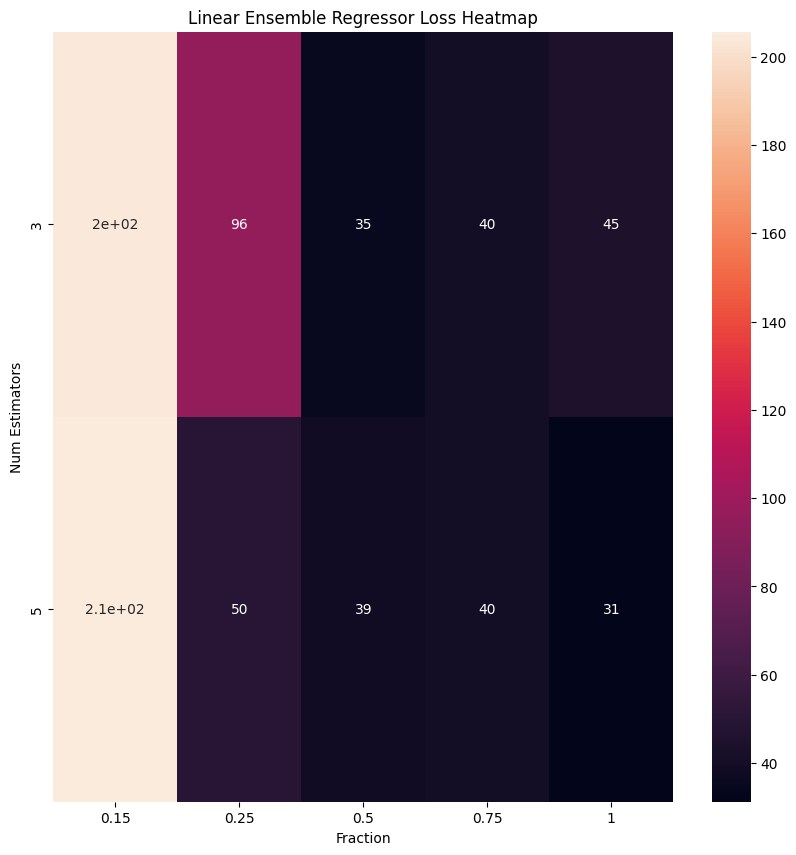

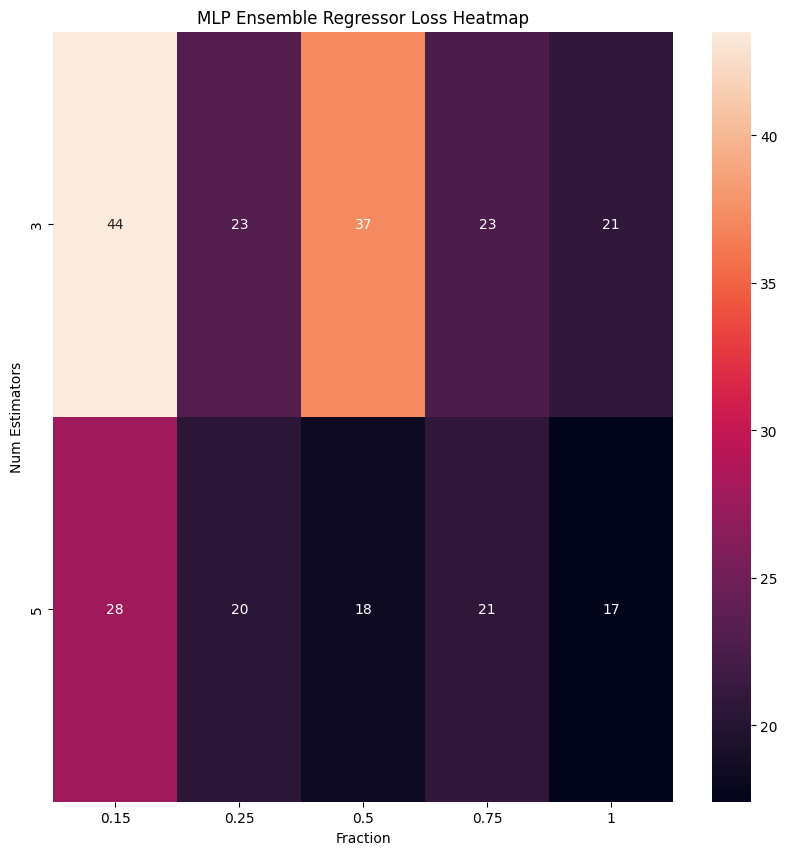

In [86]:
base_models    = ["DT", "Linear", "MLP"]
num_estimators = [3, 5]
fractions      = [0.15, 0.25, 0.5, 0.75, 1]

for model_index, model_type in enumerate(base_models):
    plt.figure(figsize=(10, 10))

    heatmap_losses = np.zeros((len(num_estimators), len(fractions)))

    for i, num_estimator in enumerate(num_estimators):
        for j, fraction in enumerate(fractions):
            ensem_model = EnsembleRegressor(base_model_type=model_type, num_estimators=num_estimator, fraction=fraction, bootstrap=True, voting='soft', progress=False)
            ensem_model.fit(housing_train_X, housing_train_Y)

            heatmap_losses[i, j] = mse(housing_test_Y, ensem_model.predict(housing_test_X, housing_test_Y))

    sns.heatmap(heatmap_losses, annot=True, xticklabels=fractions, yticklabels=num_estimators)
    plt.xlabel("Fraction")
    plt.ylabel("Num Estimators")
    plt.title(f"{model_type} Ensemble Regressor Loss Heatmap")

    plt.show()

## Task 3.2.4 - Comparision of individual models vs ensemble model

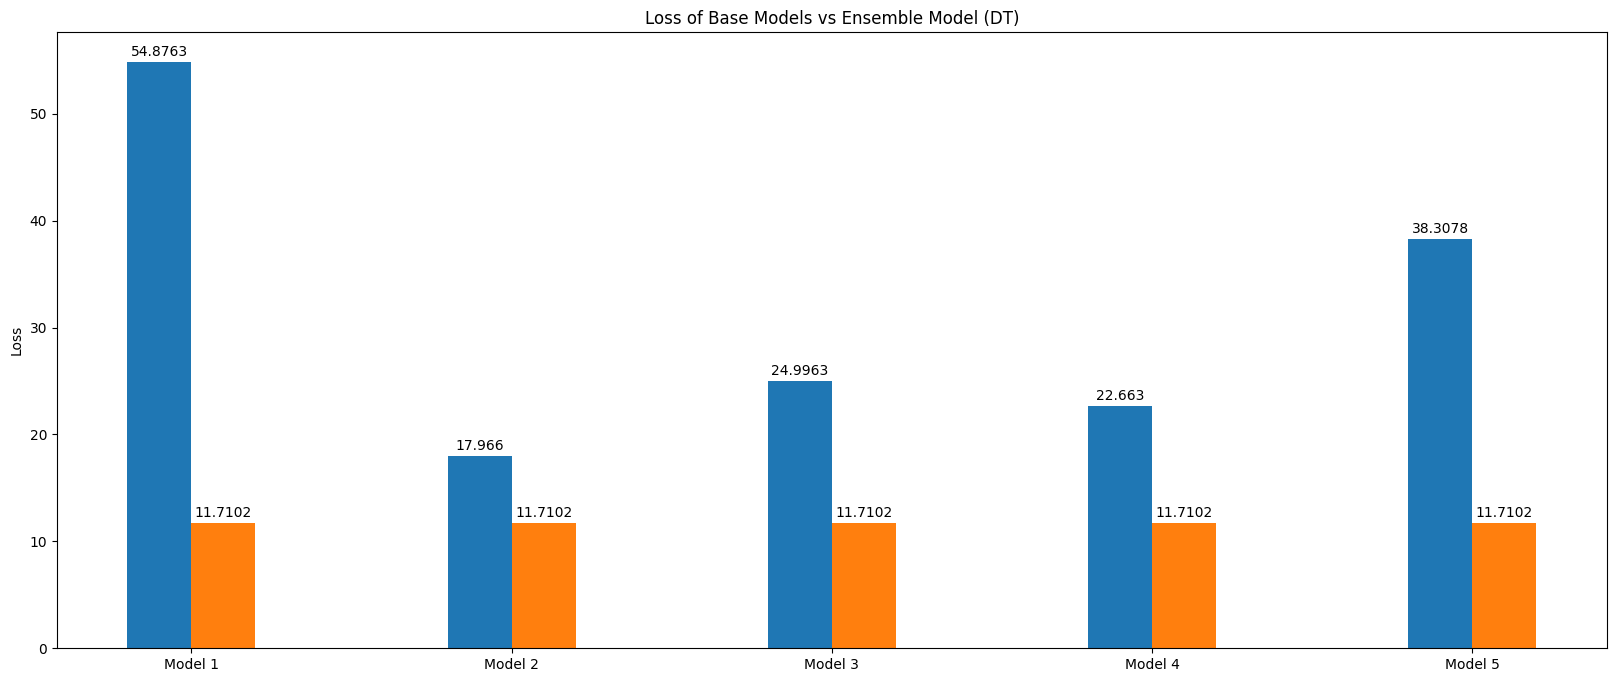

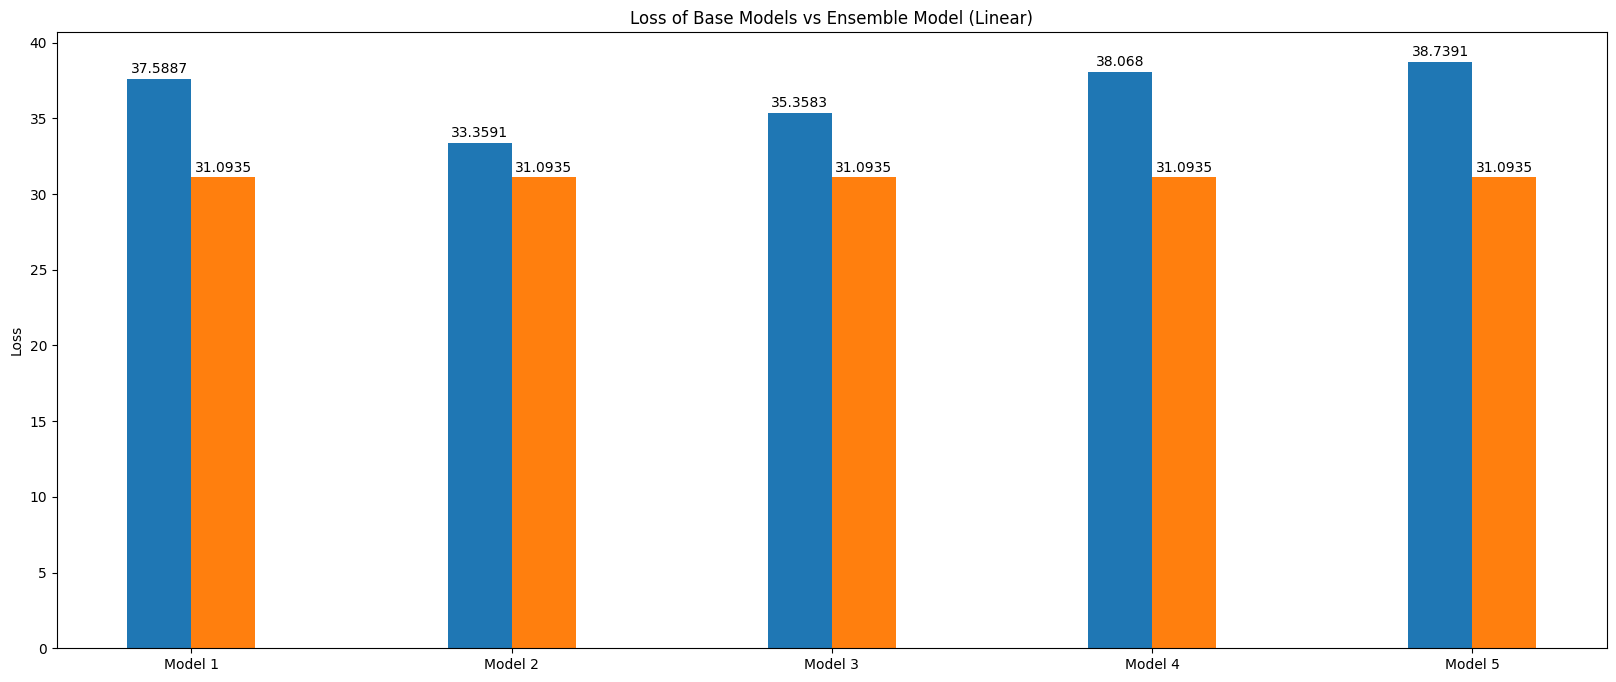

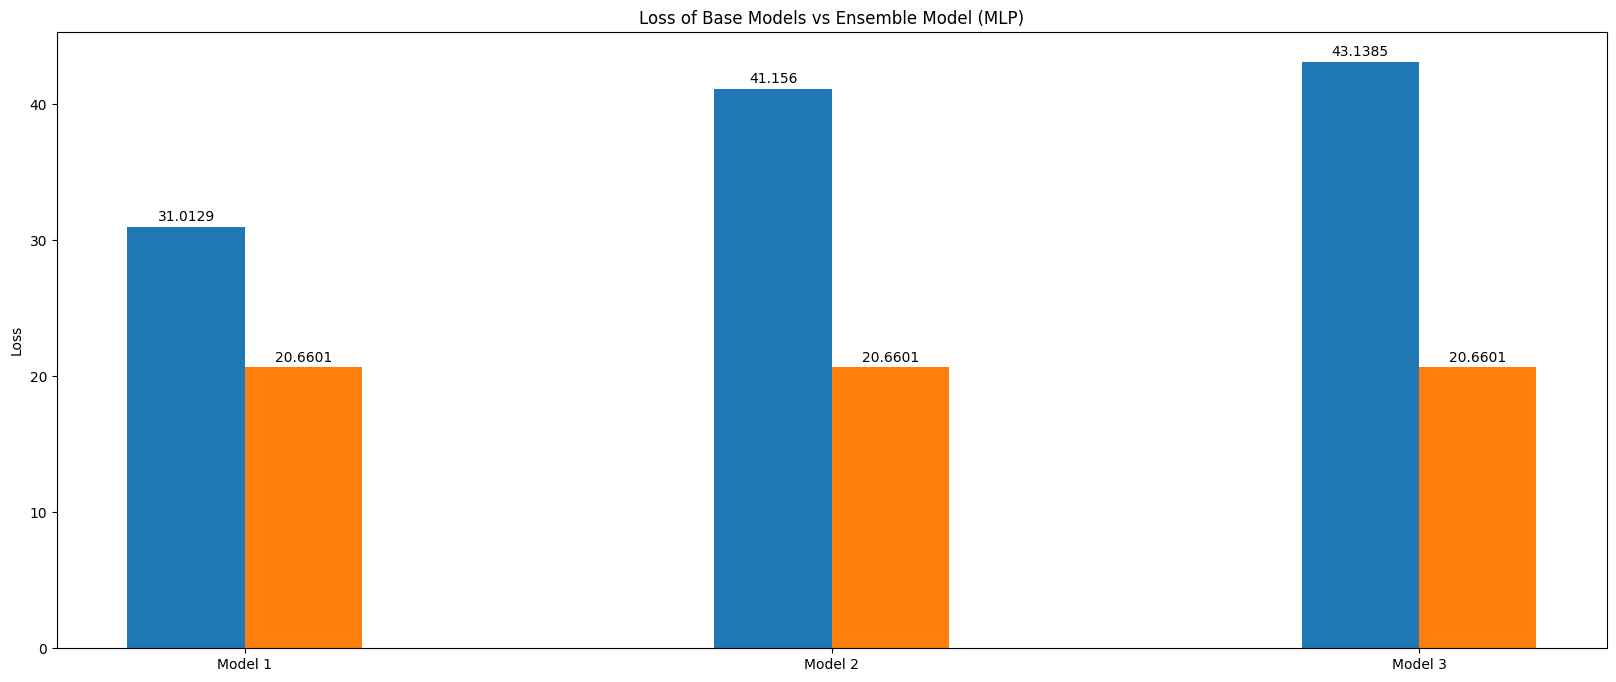

In [114]:
best_base_models = [
    EnsembleRegressor(base_model_type='DT',     num_estimators=5, fraction=0.75, bootstrap=False, voting='soft', progress=False),
    EnsembleRegressor(base_model_type='Linear', num_estimators=5, fraction=0.75, bootstrap=False, voting='soft', progress=False),
    EnsembleRegressor(base_model_type='MLP',    num_estimators=3, fraction=1,    bootstrap=True,  voting='soft', progress=False)
]

for model_index, best_model in enumerate(best_base_models):
    plt.figure(figsize=(20, 8))

    best_model.fit(housing_train_X, housing_train_Y)

    losses = []

    for model in best_model.models:
        losses.append(mse(housing_test_Y, model.predict(housing_test_X)))

    x = np.arange(len(best_model.models))
    width = 0.2
    multiplier = 0

    base_bar = plt.bar(x, losses, width, label=losses)
    plt.bar_label(base_bar, padding=2)

    loss = mse(housing_test_Y, best_model.predict(housing_test_X, housing_test_Y))
    model_bar = plt.bar(x + width, [loss] * len(best_model.models), width, label=loss)
    plt.bar_label(model_bar, padding=2)

    plt.ylabel('Loss')
    plt.xticks(x + width / 2, [f"Model {i + 1}" for i in range(len(best_model.models))])
    plt.title(f"Loss of Base Models vs Ensemble Model ({best_model.base_model_type})")

    plt.show()

## Task 3.3 - Stacking

## Task 3.3.1 - Stacking Classifier

In [70]:
class StackingClassifier():
    def __init__(self, level_0_estimators=["DT", "Logistic", "MLP"], level_1_estimator="DT", methodology="Stacking", progress=True):
        self.level_0_estimators = level_0_estimators
        self.level_1_estimator  = level_1_estimator
        self.methodology        = methodology
        self.level_0_models     = []
        self.level_1_model      = None
        self.progress           = progress

        for base_model_type in level_0_estimators:
            if base_model_type == "DT":
                self.level_0_models.append(EnsembleClassifier(base_model_type=base_model_type, num_estimators=5, fraction=1, bootstrap=False, voting='soft', progress=False))
            elif base_model_type == "Logistic":
                self.level_0_models.append(EnsembleClassifier(base_model_type=base_model_type, num_estimators=5, fraction=0.25, bootstrap=False, voting='soft', progress=False))
            elif base_model_type == "MLP":
                self.level_0_models.append(EnsembleClassifier(base_model_type=base_model_type, num_estimators=5, fraction=0.75, bootstrap=False, voting='hard', progress=False))

        if level_1_estimator == "DT":
            self.level_1_model = DTC(criterion="gini", max_depth=10, max_leaf_nodes=None)
        elif level_1_estimator == "Logistic":
            self.level_1_model = MultiLogRegressor(epochs=5000, lr=0.1, progress=False)

    def fit(self, X, y):
        if self.methodology == "Stacking":
            skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=27)

            new_X = np.zeros((X.shape[0], len(self.level_0_estimators)))
            new_y = np.zeros((y.shape[0], 1))

            for i, model in enumerate(self.level_0_models):
                for j, (train_index, test_index) in enumerate(skf.split(X, y)):
                    if self.progress is True:
                        print(f"Fitting model {i + 1}/{len(self.level_0_estimators)}...Fold {j + 1}/4...")

                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    model.fit(X_train, y_train)

                    new_X[test_index, i] = np.array(model.predict(X_test))
                    new_y[test_index, :] = np.reshape(y_test, (-1, 1))

            for model in self.level_0_models:
                model.fit(X, y)
            
            self.level_1_model.fit(new_X, new_y)

        elif self.methodology == "Blending":
            X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=0.7, stratify=y)

            new_X_holdout = np.zeros((X_holdout.shape[0], X_holdout.shape[1] + len(self.level_0_estimators)))
            new_X_holdout[:, :X_holdout.shape[1]] = X_holdout

            for i, model in enumerate(self.level_0_models):
                if self.progress is True:
                    print(f"Fitting model {i + 1}/{len(self.level_0_estimators)}...")

                model.fit(X_train, y_train)

                new_X_holdout[:, X_holdout.shape[1] + i] = np.array(model.predict(X_holdout))

            self.level_1_model.fit(new_X_holdout, y_holdout)

    def predict(self, X):
        if self.methodology == "Stacking":
            new_X = np.zeros((X.shape[0], len(self.level_0_estimators)))

            for i, model in enumerate(self.level_0_models):
                new_X[:, i] = np.array(model.predict(X))

            return self.level_1_model.predict(new_X)

        elif self.methodology == "Blending":
            new_X = np.zeros((X.shape[0], X.shape[1] + len(self.level_0_estimators)))
            new_X[:, :X.shape[1]] = X

            for i, model in enumerate(self.level_0_models):
                new_X[:, X.shape[1] + i] = np.array(model.predict(X))

            return self.level_1_model.predict(new_X)

In [71]:
sc = StackingClassifier(methodology="Blending")
sc.fit(wine_train_X, wine_train_Y)

Fitting model 1/3...
Fitting model 2/3...
Fitting model 3/3...


In [72]:
sc_test_preds = sc.predict(wine_test_X)
sc_test_score = accuracy_score(wine_test_Y, sc_test_preds)
print(f"Test Accuracy: {sc_test_score}")

Test Accuracy: 0.45930232558139533


## Task 3.3.2 - Hyperparameter Tuning

In [73]:
# level_0_estimator_list = ["DT", "Logistic", "MLP"]
# level_1_estimator_list = ["DT", "Logistic"]
# stacking_methodologies = ["Stacking", "Blending"]

# stacking_classifier_params_df = pd.DataFrame(columns=["Level_0_Estimator", "Level_1_Estimator", "Methodology", "Train_Accuracy", "Val_Accuracy", "Test_Accuracy"])
# num_fitted = 0

# for level_0_estimator in level_0_estimator_list:
#     for level_1_estimator in level_1_estimator_list:
#         for stacking_methodology in stacking_methodologies:
#             sc = StackingClassifier(level_0_estimators=[level_0_estimator, level_0_estimator, level_0_estimator], level_1_estimator=level_1_estimator, methodology=stacking_methodology, progress=False)
#             sc.fit(wine_train_X, wine_train_Y)

#             num_fitted += 1
#             print(f"Model {level_0_estimator} - {level_1_estimator} - {stacking_methodology} fitted...{num_fitted}/12")
            
#             model_params = {
#                 "Level_0_Estimator" : level_0_estimator,
#                 "Level_1_Estimator" : level_1_estimator,
#                 "Methodology"       : stacking_methodology,
#                 "Train_Accuracy"    : accuracy_score(wine_train_Y, sc.predict(wine_train_X)),
#                 "Val_Accuracy"      : accuracy_score(wine_val_Y,   sc.predict(wine_val_X)),
#                 "Test_Accuracy"     : accuracy_score(wine_test_Y,  sc.predict(wine_test_X))
#             }

#             stacking_classifier_params_df = pd.concat([stacking_classifier_params_df, pd.DataFrame([model_params])], ignore_index=True)

# dt_stacking_classifier_params_df  = stacking_classifier_params_df[stacking_classifier_params_df["Level_0_Estimator"] == 'DT']
# dt_stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("DT Stacking Classifier Parameters")
# display(dt_stacking_classifier_params_df)
# print("=================================\n")

# log_stacking_classifier_params_df = stacking_classifier_params_df[stacking_classifier_params_df["Level_0_Estimator"] == 'Logistic']
# log_stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("Logistic Stacking Classifier Parameters")
# display(log_stacking_classifier_params_df)
# print("=================================\n")

# mlp_stacking_classifier_params_df = stacking_classifier_params_df[stacking_classifier_params_df["Level_0_Estimator"] == 'MLP']
# mlp_stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("MLP Stacking Classifier Parameters")
# display(mlp_stacking_classifier_params_df)
# print("=================================\n")

# stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)
# print("Stacking Classifier Parameters")
# display(stacking_classifier_params_df)
# print("=================================\n")

Model DT - DT - Stacking fitted...1/12
Model DT - DT - Blending fitted...2/12
Model DT - Logistic - Stacking fitted...3/12
Model DT - Logistic - Blending fitted...4/12
Model Logistic - DT - Stacking fitted...5/12
Model Logistic - DT - Blending fitted...6/12
Model Logistic - Logistic - Stacking fitted...7/12
Model Logistic - Logistic - Blending fitted...8/12
Model MLP - DT - Stacking fitted...9/12
Model MLP - DT - Blending fitted...10/12
Model MLP - Logistic - Stacking fitted...11/12
Model MLP - Logistic - Blending fitted...12/12
DT Stacking Classifier Parameters


/tmp/ipykernel_18167/1381586841.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Accuracy,Val_Accuracy,Test_Accuracy
0,DT,DT,Stacking,0.77375,0.602339,0.581395
1,DT,DT,Blending,0.67625,0.578947,0.511628
2,DT,Logistic,Stacking,0.53375,0.461988,0.465116
3,DT,Logistic,Blending,0.40375,0.345029,0.389535



Logistic Stacking Classifier Parameters


/tmp/ipykernel_18167/1381586841.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Accuracy,Val_Accuracy,Test_Accuracy
5,Logistic,DT,Blending,0.59750,0.555556,0.465116
4,Logistic,DT,Stacking,0.43625,0.415205,0.418605
6,Logistic,Logistic,Stacking,0.40500,0.403509,0.401163
7,Logistic,Logistic,Blending,0.24875,0.269006,0.226744



MLP Stacking Classifier Parameters


/tmp/ipykernel_18167/1381586841.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlp_stacking_classifier_params_df.sort_values(by=["Val_Accuracy"], ascending=False, inplace=True)


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Accuracy,Val_Accuracy,Test_Accuracy
9,MLP,DT,Blending,0.64125,0.485380,0.558140
8,MLP,DT,Stacking,0.44000,0.450292,0.453488
11,MLP,Logistic,Blending,0.43250,0.421053,0.453488
10,MLP,Logistic,Stacking,0.40250,0.397661,0.395349



Stacking Classifier Parameters


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Accuracy,Val_Accuracy,Test_Accuracy
0,DT,DT,Stacking,0.77375,0.602339,0.581395
1,DT,DT,Blending,0.67625,0.578947,0.511628
5,Logistic,DT,Blending,0.59750,0.555556,0.465116
9,MLP,DT,Blending,0.64125,0.485380,0.558140
2,DT,Logistic,Stacking,0.53375,0.461988,0.465116
8,MLP,DT,Stacking,0.44000,0.450292,0.453488
11,MLP,Logistic,Blending,0.43250,0.421053,0.453488
4,Logistic,DT,Stacking,0.43625,0.415205,0.418605
6,Logistic,Logistic,Stacking,0.40500,0.403509,0.401163
10,MLP,Logistic,Stacking,0.40250,0.397661,0.395349


## Task 3.3.3 - Accuracy, Training Time vs best model of each type for Bagging vs Stacking Classifiers

DT Bagging done...
Logistic Bagging done...
MLP Bagging done...
DT Stacking done...
Logistic Stacking done...
MLP Stacking done...


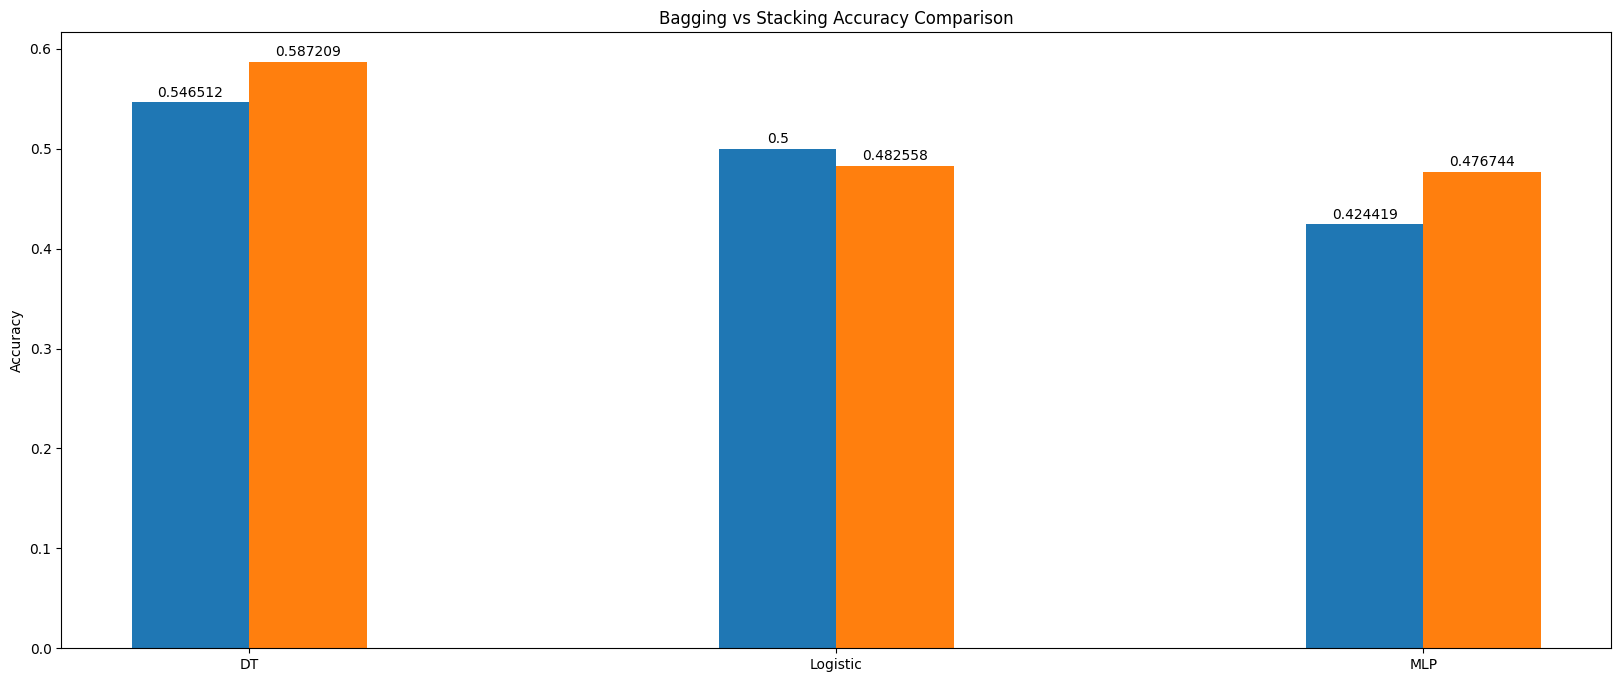

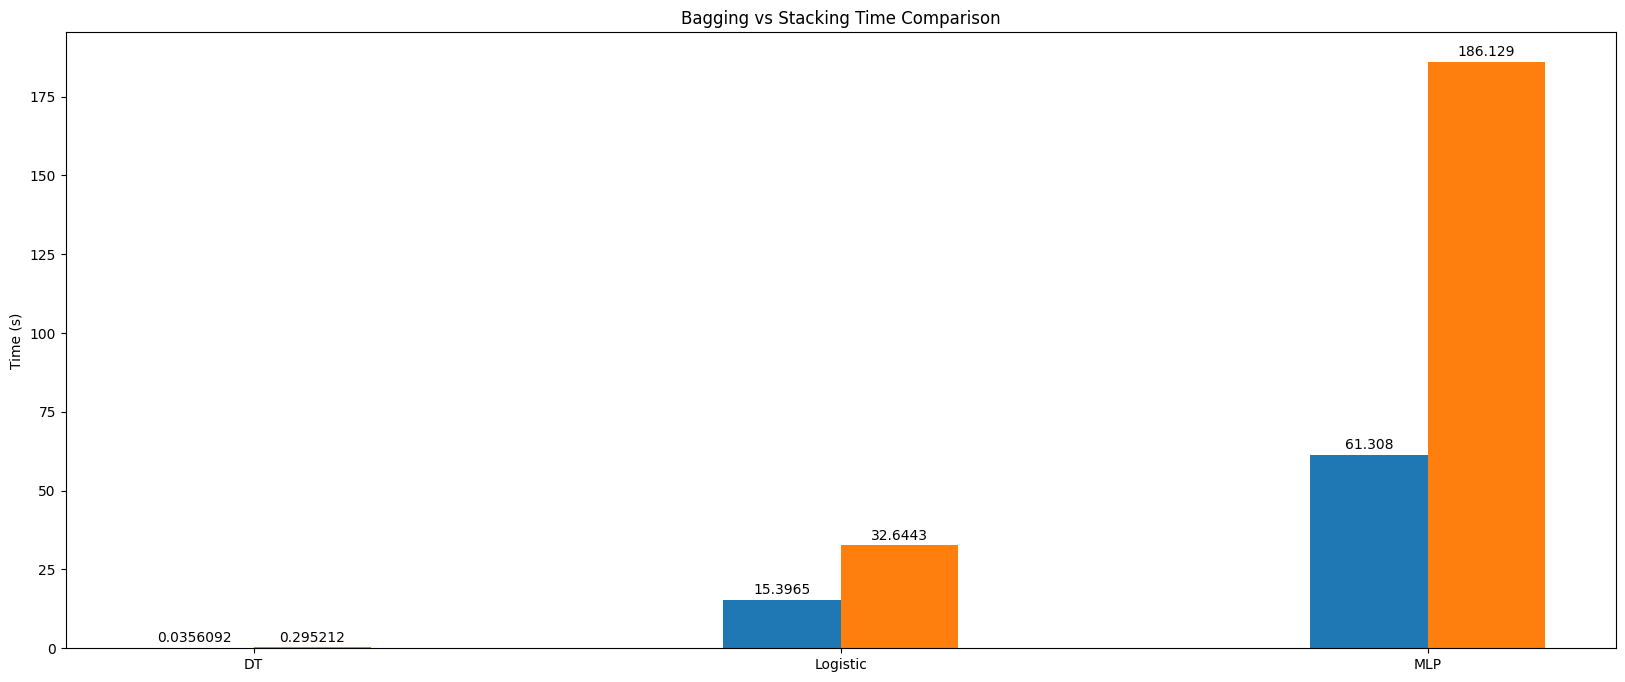

In [78]:
bagging_dt_model = EnsembleClassifier(base_model_type="DT", num_estimators=5, fraction=1, bootstrap=False, voting='soft', progress=False)
bagging_dt_time  = time()
bagging_dt_model.fit(wine_train_X, wine_train_Y)
bagging_dt_time  = time() - bagging_dt_time
bagging_dt_acc   = accuracy_score(wine_test_Y, bagging_dt_model.predict(wine_test_X))
print("DT Bagging done...")

bagging_log_model = EnsembleClassifier(base_model_type="Logistic", num_estimators=5, fraction=0.25, bootstrap=False, voting='soft', progress=False)
bagging_log_time  = time()
bagging_log_model.fit(wine_train_X, wine_train_Y)
bagging_log_time  = time() - bagging_log_time
bagging_log_acc   = accuracy_score(wine_test_Y, bagging_log_model.predict(wine_test_X))
print("Logistic Bagging done...")

bagging_mlp_model = EnsembleClassifier(base_model_type="MLP", num_estimators=5, fraction=0.75, bootstrap=False, voting='hard', progress=False)
bagging_mlp_time  = time()
bagging_mlp_model.fit(wine_train_X, wine_train_Y)
bagging_mlp_time  = time() - bagging_mlp_time
bagging_mlp_acc   = accuracy_score(wine_test_Y, bagging_mlp_model.predict(wine_test_X))
print("MLP Bagging done...")

stacking_dt_model = StackingClassifier(level_0_estimators=["DT", "DT", "DT"], level_1_estimator="DT", methodology="Stacking", progress=False)
stacking_dt_time  = time()
stacking_dt_model.fit(wine_train_X, wine_train_Y)
stacking_dt_time  = time() - stacking_dt_time
stacking_dt_acc   = accuracy_score(wine_test_Y, stacking_dt_model.predict(wine_test_X))
print("DT Stacking done...")

stacking_log_model = StackingClassifier(level_0_estimators=["Logistic", "Logistic", "Logistic"], level_1_estimator="DT", methodology="Blending", progress=False)
stacking_log_time  = time()
stacking_log_model.fit(wine_train_X, wine_train_Y)
stacking_log_time  = time() - stacking_log_time
stacking_log_acc   = accuracy_score(wine_test_Y, stacking_log_model.predict(wine_test_X))
print("Logistic Stacking done...")

stacking_mlp_model = StackingClassifier(level_0_estimators=["MLP", "MLP", "MLP"], level_1_estimator="DT", methodology="Blending", progress=False)
stacking_mlp_time  = time()
stacking_mlp_model.fit(wine_train_X, wine_train_Y)
stacking_mlp_time  = time() - stacking_mlp_time
stacking_mlp_acc   = accuracy_score(wine_test_Y, stacking_mlp_model.predict(wine_test_X))
print("MLP Stacking done...")

x = np.arange(3)
width = 0.2
multiplier = 0

plt.figure(figsize=(20, 8))

bagging_bar = plt.bar(x, [bagging_dt_acc, bagging_log_acc, bagging_mlp_acc], width, label=[bagging_dt_acc, bagging_log_acc, bagging_mlp_acc])
plt.bar_label(bagging_bar, padding=2)

stacking_bar = plt.bar(x + width, [stacking_dt_acc, stacking_log_acc, stacking_mlp_acc], width, label=[stacking_dt_acc, stacking_log_acc, stacking_mlp_acc])
plt.bar_label(stacking_bar, padding=2)

plt.ylabel('Accuracy')
plt.xticks(x + width / 2, ['DT', 'Logistic', 'MLP'])
plt.title(f"Bagging vs Stacking Accuracy Comparison")

plt.show()

x = np.arange(3)
width = 0.2
multiplier = 0

plt.figure(figsize=(20, 8))

bagging_bar = plt.bar(x, [bagging_dt_time, bagging_log_time, bagging_mlp_time], width, label=[bagging_dt_time, bagging_log_time, bagging_mlp_time])
plt.bar_label(bagging_bar, padding=2)

stacking_bar = plt.bar(x + width, [stacking_dt_time, stacking_log_time, stacking_mlp_time], width, label=[stacking_dt_time, stacking_log_time, stacking_mlp_time])
plt.bar_label(stacking_bar, padding=2)

plt.ylabel('Time (s)')
plt.xticks(x + width / 2, ['DT', 'Logistic', 'MLP'])
plt.title(f"Bagging vs Stacking Time Comparison")

plt.show()

## Task 3.3.1 - Stacking Regressor

In [115]:
class StackingRegressor():
    def __init__(self, level_0_estimators=["DT", "Linear", "MLP"], level_1_estimator="DT", methodology="Stacking", progress=True):
        self.level_0_estimators = level_0_estimators
        self.level_1_estimator  = level_1_estimator
        self.methodology        = methodology
        self.level_0_models     = []
        self.level_1_model      = None
        self.progress           = progress

        for base_model_type in level_0_estimators:
            if base_model_type == "DT":
                self.level_0_models.append(EnsembleRegressor(base_model_type=base_model_type, num_estimators=5, fraction=0.75, bootstrap=False, voting='soft', progress=False))
            elif base_model_type == "Linear":
                self.level_0_models.append(EnsembleRegressor(base_model_type=base_model_type, num_estimators=5, fraction=0.75, bootstrap=False, voting='soft', progress=False))
            elif base_model_type == "MLP":
                self.level_0_models.append(EnsembleRegressor(base_model_type=base_model_type, num_estimators=3, fraction=1,    bootstrap=True,  voting='soft', progress=False))

        if level_1_estimator == "DT":
            self.level_1_model = DTR()
        elif level_1_estimator == "Linear":
            self.level_1_model = LinearRegresor(progress=False)

    def fit(self, X, y):
        if self.methodology == "Stacking":
            skf = KFold(n_splits=5, shuffle=True, random_state=27)

            new_X = np.zeros((X.shape[0], len(self.level_0_estimators)))
            new_y = np.zeros((y.shape[0], 1))

            for i, model in enumerate(self.level_0_models):
                for j, (train_index, test_index) in enumerate(skf.split(X, y)):
                    if self.progress is True:
                        print(f"Fitting model {i + 1}/{len(self.level_0_estimators)}...Fold {j + 1}/5...")

                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    model.fit(X_train, y_train)

                    new_X[test_index, i] = np.reshape(model.predict(X_test, y_test), (-1))
                    new_y[test_index, :] = np.reshape(y_test, (-1, 1))

            for model in self.level_0_models:
                model.fit(X, y)
            
            self.level_1_model.fit(new_X, new_y)

        elif self.methodology == "Blending":
            X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=0.7)

            new_X_holdout = np.zeros((X_holdout.shape[0], X_holdout.shape[1] + len(self.level_0_estimators)))
            new_X_holdout[:, :X_holdout.shape[1]] = X_holdout

            for i, model in enumerate(self.level_0_models):
                if self.progress is True:
                    print(f"Fitting model {i + 1}/{len(self.level_0_estimators)}...")

                model.fit(X_train, y_train)

                new_X_holdout[:, X_holdout.shape[1] + i] = np.reshape(model.predict(X_holdout, y_holdout), (-1))

            self.level_1_model.fit(new_X_holdout, y_holdout)

    def predict(self, X, y):
        if self.methodology == "Stacking":
            new_X = np.zeros((X.shape[0], len(self.level_0_estimators)))

            for i, model in enumerate(self.level_0_models):
                new_X[:, i] = np.reshape(model.predict(X, y), (-1))

            return self.level_1_model.predict(new_X)

        elif self.methodology == "Blending":
            new_X = np.zeros((X.shape[0], X.shape[1] + len(self.level_0_estimators)))
            new_X[:, :X.shape[1]] = X

            for i, model in enumerate(self.level_0_models):
                new_X[:, X.shape[1] + i] = np.reshape(model.predict(X, y), (-1))

            return self.level_1_model.predict(new_X)

In [116]:
sr = StackingRegressor(methodology="Blending")
sr.fit(housing_train_X, housing_train_Y)

Fitting model 1/3...
Fitting model 2/3...
Fitting model 3/3...


In [117]:
sr_preds = sr.predict(housing_test_X, housing_test_Y)
sr_score = mse(housing_test_Y, sr_preds)
print(f"Test MSE: {sr_score}")

Test MSE: 20.61052631578947


## Task 3.3.2 - Hyperparameter Tuning

In [118]:
# level_0_estimator_list = ["DT", "Linear", "MLP"]
# level_1_estimator_list = ["DT", "Linear"]
# stacking_methodologies = ["Stacking", "Blending"]

# stacking_regressor_params_df = pd.DataFrame(columns=["Level_0_Estimator", "Level_1_Estimator", "Methodology", "Train_Loss", "Val_Loss", "Test_Loss"])
# num_fitted = 0

# for level_0_estimator in level_0_estimator_list:
#     for level_1_estimator in level_1_estimator_list:
#         for stacking_methodology in stacking_methodologies:
#             sr = StackingRegressor(level_0_estimators=[level_0_estimator, level_0_estimator, level_0_estimator], level_1_estimator=level_1_estimator, methodology=stacking_methodology, progress=False)
#             sr.fit(housing_train_X, housing_train_Y)

#             num_fitted += 1
#             print(f"Model {level_0_estimator} - {level_1_estimator} - {stacking_methodology} fitted...{num_fitted}/12")
            
#             model_params = {
#                 "Level_0_Estimator" : level_0_estimator,
#                 "Level_1_Estimator" : level_1_estimator,
#                 "Methodology"       : stacking_methodology,
#                 "Train_Loss"        : mse(housing_train_Y, sr.predict(housing_train_X, housing_train_Y)),
#                 "Val_Loss"          : mse(housing_val_Y,   sr.predict(housing_val_X,   housing_val_Y)),
#                 "Test_Loss"         : mse(housing_test_Y,  sr.predict(housing_test_X,  housing_test_Y))
#             }

#             stacking_regressor_params_df = pd.concat([stacking_regressor_params_df, pd.DataFrame([model_params])], ignore_index=True)

# dt_stacking_regressor_params_df  = stacking_regressor_params_df[stacking_regressor_params_df["Level_0_Estimator"] == 'DT']
# dt_stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
# print("DT Stacking Regressor Parameters")
# display(dt_stacking_regressor_params_df)
# print("=================================\n")

# lin_stacking_regressor_params_df = stacking_regressor_params_df[stacking_regressor_params_df["Level_0_Estimator"] == 'Linear']
# lin_stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
# print("Linear Stacking Regressor Parameters")
# display(lin_stacking_regressor_params_df)
# print("=================================\n")

# mlp_stacking_regressor_params_df = stacking_regressor_params_df[stacking_regressor_params_df["Level_0_Estimator"] == 'MLP']
# mlp_stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
# print("MLP Stacking Regressor Parameters")
# display(mlp_stacking_regressor_params_df)
# print("=================================\n")

# stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)
# print("Stacking Regressor Parameters")
# display(stacking_regressor_params_df)
# print("=================================\n")

Model DT - DT - Stacking fitted...1/12
Model DT - DT - Blending fitted...2/12
Model DT - Linear - Stacking fitted...3/12
Model DT - Linear - Blending fitted...4/12
Model Linear - DT - Stacking fitted...5/12
Model Linear - DT - Blending fitted...6/12
Model Linear - Linear - Stacking fitted...7/12
Model Linear - Linear - Blending fitted...8/12
Model MLP - DT - Stacking fitted...9/12
Model MLP - DT - Blending fitted...10/12
Model MLP - Linear - Stacking fitted...11/12
Model MLP - Linear - Blending fitted...12/12
DT Stacking Regressor Parameters


/tmp/ipykernel_18167/1870377857.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Loss,Val_Loss,Test_Loss
2,DT,Linear,Stacking,2.203330,7.140947,12.897328
0,DT,DT,Stacking,5.394209,9.923816,13.882368
3,DT,Linear,Blending,6.943184,13.332272,12.229405
1,DT,DT,Blending,12.939040,26.138684,29.766447



Linear Stacking Regressor Parameters


/tmp/ipykernel_18167/1870377857.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Loss,Val_Loss,Test_Loss
6,Linear,Linear,Stacking,22.778879,18.803182,29.953753
4,Linear,DT,Stacking,28.378616,31.396711,41.327763
5,Linear,DT,Blending,28.862994,40.484342,40.923421
7,Linear,Linear,Blending,82137.405698,65705.745520,99222.243812



MLP Stacking Regressor Parameters


/tmp/ipykernel_18167/1870377857.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlp_stacking_regressor_params_df.sort_values(by=["Val_Loss"], ascending=True, inplace=True)


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Loss,Val_Loss,Test_Loss
10,MLP,Linear,Stacking,9.437475,11.025734,16.835687
8,MLP,DT,Stacking,12.858842,13.894079,16.455526
11,MLP,Linear,Blending,19.263326,16.630912,29.790055
9,MLP,DT,Blending,24.521836,30.940263,40.189474



Stacking Regressor Parameters


,Level_0_Estimator,Level_1_Estimator,Methodology,Train_Loss,Val_Loss,Test_Loss
2,DT,Linear,Stacking,2.203330,7.140947,12.897328
0,DT,DT,Stacking,5.394209,9.923816,13.882368
10,MLP,Linear,Stacking,9.437475,11.025734,16.835687
3,DT,Linear,Blending,6.943184,13.332272,12.229405
8,MLP,DT,Stacking,12.858842,13.894079,16.455526
11,MLP,Linear,Blending,19.263326,16.630912,29.790055
6,Linear,Linear,Stacking,22.778879,18.803182,29.953753
1,DT,DT,Blending,12.939040,26.138684,29.766447
9,MLP,DT,Blending,24.521836,30.940263,40.189474
4,Linear,DT,Stacking,28.378616,31.396711,41.327763


## Task 3.3.3 - Loss, Training Time vs best model of each type for Bagging vs Stacking Regressors

DT Bagging done...
Logistic Bagging done...
MLP Bagging done...
DT Stacking done...
Logistic Stacking done...
MLP Stacking done...


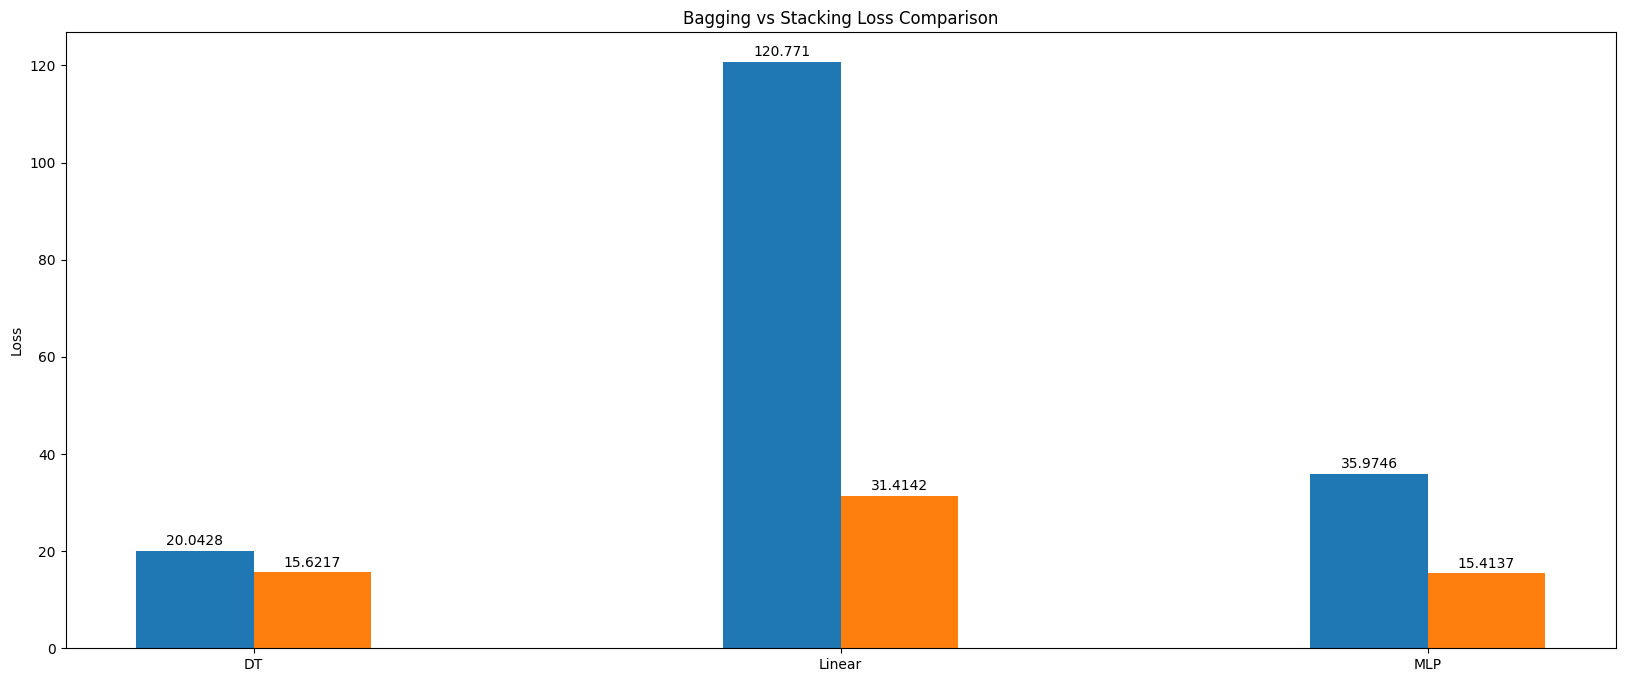

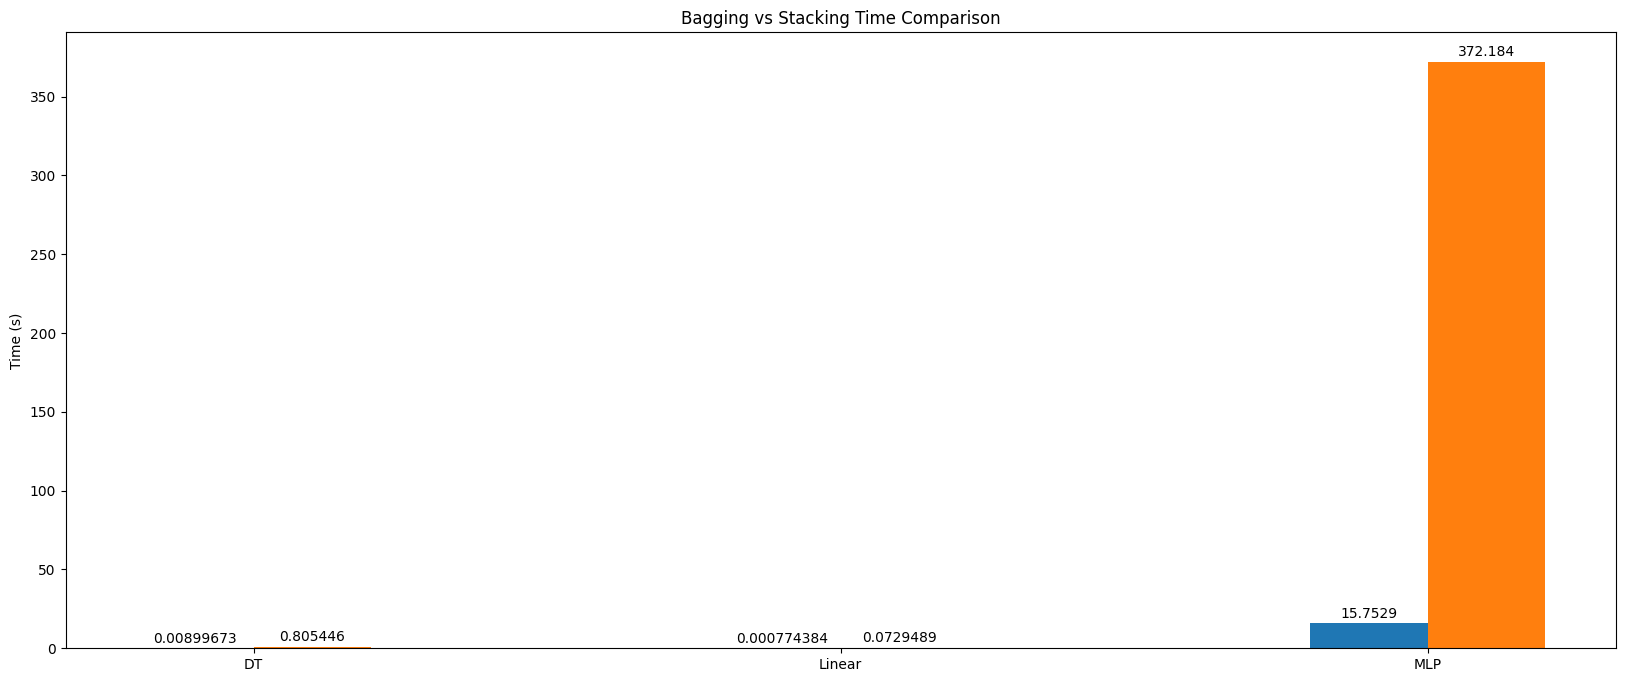

In [122]:
bagging_dt_model = EnsembleRegressor(base_model_type='DT', num_estimators=3, fraction=0.25, bootstrap=True, voting='soft', progress=False)
bagging_dt_time  = time()
bagging_dt_model.fit(housing_train_X, housing_train_Y)
bagging_dt_time  = time() - bagging_dt_time
bagging_dt_acc   = mse(housing_test_Y, bagging_dt_model.predict(housing_test_X, housing_test_Y))
print("DT Bagging done...")

bagging_log_model = EnsembleRegressor(base_model_type='Linear', num_estimators=3, fraction=0.15, bootstrap=True, voting='soft', progress=False)
bagging_log_time  = time()
bagging_log_model.fit(housing_train_X, housing_train_Y)
bagging_log_time  = time() - bagging_log_time
bagging_log_acc   = mse(housing_test_Y, bagging_log_model.predict(housing_test_X, housing_test_Y))
print("Logistic Bagging done...")

bagging_mlp_model = EnsembleRegressor(base_model_type='MLP', num_estimators=3, fraction=0.25, bootstrap=True, voting='hard', progress=False)
bagging_mlp_time  = time()
bagging_mlp_model.fit(housing_train_X, housing_train_Y)
bagging_mlp_time  = time() - bagging_mlp_time
bagging_mlp_acc   = mse(housing_test_Y, bagging_mlp_model.predict(housing_test_X, housing_test_Y))
print("MLP Bagging done...")

stacking_dt_model = StackingRegressor(level_0_estimators=["DT", "DT", "DT"], level_1_estimator="DT", methodology="Stacking", progress=False)
stacking_dt_time  = time()
stacking_dt_model.fit(housing_train_X, housing_train_Y)
stacking_dt_time  = time() - stacking_dt_time
stacking_dt_acc   = mse(housing_test_Y, stacking_dt_model.predict(housing_test_X, housing_test_Y))
print("DT Stacking done...")

stacking_log_model = StackingRegressor(level_0_estimators=["Linear", "Linear", "Linear"], level_1_estimator="Linear", methodology="Stacking", progress=False)
stacking_log_time  = time()
stacking_log_model.fit(housing_train_X, housing_train_Y)
stacking_log_time  = time() - stacking_log_time
stacking_log_acc   = mse(housing_test_Y, stacking_log_model.predict(housing_test_X, housing_test_Y))
print("Logistic Stacking done...")

stacking_mlp_model = StackingRegressor(level_0_estimators=["MLP", "MLP", "MLP"], level_1_estimator="Linear", methodology="Stacking", progress=False)
stacking_mlp_time  = time()
stacking_mlp_model.fit(housing_train_X, housing_train_Y)
stacking_mlp_time  = time() - stacking_mlp_time
stacking_mlp_acc   = mse(housing_test_Y, stacking_mlp_model.predict(housing_test_X, housing_test_Y))
print("MLP Stacking done...")

x = np.arange(3)
width = 0.2
multiplier = 0

plt.figure(figsize=(20, 8))

bagging_bar = plt.bar(x, [bagging_dt_acc, bagging_log_acc, bagging_mlp_acc], width, label=[bagging_dt_acc, bagging_log_acc, bagging_mlp_acc])
plt.bar_label(bagging_bar, padding=2)

stacking_bar = plt.bar(x + width, [stacking_dt_acc, stacking_log_acc, stacking_mlp_acc], width, label=[stacking_dt_acc, stacking_log_acc, stacking_mlp_acc])
plt.bar_label(stacking_bar, padding=2)

plt.ylabel('Loss')
plt.xticks(x + width / 2, ['DT', 'Linear', 'MLP'])
plt.title(f"Bagging vs Stacking Loss Comparison")

plt.show()

x = np.arange(3)
width = 0.2
multiplier = 0

plt.figure(figsize=(20, 8))

bagging_bar = plt.bar(x, [bagging_dt_time, bagging_log_time, bagging_mlp_time], width, label=[bagging_dt_time, bagging_log_time, bagging_mlp_time])
plt.bar_label(bagging_bar, padding=2)

stacking_bar = plt.bar(x + width, [stacking_dt_time, stacking_log_time, stacking_mlp_time], width, label=[stacking_dt_time, stacking_log_time, stacking_mlp_time])
plt.bar_label(stacking_bar, padding=2)

plt.ylabel('Time (s)')
plt.xticks(x + width / 2, ['DT', 'Linear', 'MLP'])
plt.title(f"Bagging vs Stacking Time Comparison")

plt.show()